In [131]:
import numpy as np
import matplotlib.pyplot as plt


# from hnc_custom_screeningOZ_multiscale import  HNC_solver
from hnc import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [107]:
N_bins, R_max = 2000, 10

In [108]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3, tol=1e-8, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='best', add_bridge=False, bridge='yukawa' ):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n_in_AU, which_Tij=which_Tij)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=tol,
                     kappa_multiscale=5, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), qsp.βvei(hnc1.r_array)],
                            [qsp.βvei(hnc1.r_array), qsp.βvee(hnc1.r_array)]])

    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e8)

    return hnc1, qsp

In [109]:
def run_mixture_hnc(n_in_per_cc, T, Z1,Z2, A1,A2, Zstar1,Zstar2, num_iterations=1e3, alpha = 1e-3, tol=1e-8, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='best', add_bridge=False, bridge='yukawa' ):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ne = (Zstar1 + Zstar2)*n_in_AU
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp_i1 = QSP_HNC(Z1, A1, Zstar1, Te, Ti, ri, ne, which_Tij=which_Tij)
    qsp_i2 = QSP_HNC(Z2, A2, Zstar2, Te, Ti, ri, ne, which_Tij=which_Tij)

    N_species = 3
    Γ0 = 1/Ti/ri
    Gamma = np.array(  [[Zstar1**2*Γ0,      Zstar1*Zstar2*Γ0, qsp_i1.Γei],
                        [Zstar1*Zstar2*Γ0,  Zstar2**2*Γ0,     qsp_i2.Γei],
                        [qsp_i1.Γei,        qsp_i2.Γei,       qsp_i2.Γee]])


    names = ["Ion-1", "Ion-2", "Electron", ] 
    rhos = np.array([  3/(4*np.pi), 3/(4*np.pi), (Zstar1+Zstar2)*3/(4*np.pi) ])
    temps = np.array([qsp_i1.Ti, qsp_i2.Ti, qsp_i1.Te_c])
    masses= np.array([qsp_i1.m_i, qsp_i2.m_i , m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=tol,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)
    
    βvii_0 = qsp_i1.βvii(hnc1.r_array)/Zstar1**2
    βu_r_matrix = np.array([[βvii_0*Zstar1**2,         βvii_0*Zstar1*Zstar2,      qsp_i1.βvei(hnc1.r_array)],
                            [βvii_0*Zstar1*Zstar2,     βvii_0*Zstar2**2,          qsp_i2.βvei(hnc1.r_array)],
                            [qsp_i1.βvei(hnc1.r_array),qsp_i2.βvei(hnc1.r_array), qsp_i1.βvee(hnc1.r_array)]])

#     if add_bridge:
#         if bridge=='ocp':
#             βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
#         elif bridge=='yukawa':
#             βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e8)

    return hnc1, qsp_i1, qsp_i2

In [110]:
def run_hnc_one_ion(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best',oz_type='standard', which_Tij='thermal' ):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n_in_AU, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3,oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

def run_hnc_one_electron(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best' ,oz_type='standard', which_Tij='thermal'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["e"] 
    kappa = 1
    rho = np.array([  Zstar*3/(4*np.pi)])
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3,oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp



In [111]:
def run_hnc_TF(n_in_per_cc, T, Z, A, Zstar,κ = 1, num_iterations=1e3, alpha = 1e-3,method='best',oz_type='standard', which_Tij='thermal' ):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n_in_AU, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)

    βu_r_matrix = np.array([[ qsp.Γii/hnc1.r_array *np.exp(-κ*hnc1.r_array)  ]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp


# Priority 1

## Cu-H mixture (HCu1)

In [223]:
ni = 1.68e+22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z1, A1, Zstar1 = 29, 63.546, 1.0010889715987994 # C
Z2, A2, Zstar2 = 1, 1 , 0.40970693987287754  # H

## C-H mixture (CH1)

In [ ]:
# ni = 4.63e23 # per cc
# Te = 2*eV 
# Ti   = 2*eV 
# Z1, A1, Zstar1 = 6, 12, 0.8438527618887307 # C
# Z2, A2, Zstar2 = 1, 1 , 0.556880186479285  # H

In [224]:
CH1, CH1qsp1, CH1qsp2  = run_mixture_hnc(ni, Te, Z1,Z2, A1,A2, Zstar1,Zstar2 ,method='fixed',alpha=0.1,num_iterations=1e3)#, c_s_r_guess=c_s_r_guess)
CH1SVT, CH1qsp1, CH1qsp2  = run_mixture_hnc(ni, Te, Z1,Z2, A1,A2, Zstar1,Zstar2 ,method='fixed',alpha=0.1,num_iterations=1e3, oz_type='svt')#, c_s_r_guess=c_s_r_guess)

Λei = 0.261
Λee = 0.370
Λei adjusted with R = 0.261
Γii=5.958, Γie=-1.967, Γee=1.965 
r_i=4.577
r_e=4.081
θ  =3.32e-01
Λei = 0.261
Λee = 0.370
Λei adjusted with R = 0.261
Γii=0.998, Γie=-0.805, Γee=1.965 
r_i=4.577
r_e=4.081
θ  =3.32e-01
0: Err in c_r: 1.25e+00, OZ: 6.63e-02, HNC: 1.54e+06, tot: 1.12e+01, tot: 1.13e+01
1: Err in c_r: 1.13e+00, OZ: 6.39e-02, HNC: 1.22e+05, tot: 1.02e+01, tot: 1.02e+01
2: Err in c_r: 1.02e+00, OZ: 6.16e-02, HNC: 2.00e+04, tot: 9.18e+00, tot: 9.21e+00
3: Err in c_r: 9.21e-01, OZ: 5.95e-02, HNC: 5.38e+03, tot: 8.29e+00, tot: 8.32e+00
4: Err in c_r: 8.32e-01, OZ: 5.74e-02, HNC: 2.07e+03, tot: 7.49e+00, tot: 7.52e+00
5: Err in c_r: 7.52e-01, OZ: 5.54e-02, HNC: 1.03e+03, tot: 6.77e+00, tot: 6.79e+00
6: Err in c_r: 6.79e-01, OZ: 5.35e-02, HNC: 6.22e+02, tot: 6.11e+00, tot: 6.14e+00
7: Err in c_r: 6.14e-01, OZ: 5.17e-02, HNC: 4.37e+02, tot: 5.52e+00, tot: 5.54e+00
8: Err in c_r: 5.54e-01, OZ: 4.99e-02, HNC: 3.44e+02, tot: 4.99e+00, tot: 5.01e+00
9: Err in c_r: 

98: Err in c_r: 4.66e-04, OZ: 1.21e-03, HNC: 1.13e-01, tot: 4.20e-03, tot: 4.43e-03
99: Err in c_r: 4.43e-04, OZ: 1.16e-03, HNC: 1.06e-01, tot: 3.99e-03, tot: 4.21e-03
100: Err in c_r: 4.21e-04, OZ: 1.11e-03, HNC: 1.00e-01, tot: 3.79e-03, tot: 4.00e-03
101: Err in c_r: 4.00e-04, OZ: 1.06e-03, HNC: 9.50e-02, tot: 3.60e-03, tot: 3.80e-03
102: Err in c_r: 3.80e-04, OZ: 1.02e-03, HNC: 9.00e-02, tot: 3.42e-03, tot: 3.62e-03
103: Err in c_r: 3.62e-04, OZ: 9.74e-04, HNC: 8.53e-02, tot: 3.26e-03, tot: 3.45e-03
104: Err in c_r: 3.45e-04, OZ: 9.32e-04, HNC: 8.10e-02, tot: 3.10e-03, tot: 3.29e-03
105: Err in c_r: 3.29e-04, OZ: 8.92e-04, HNC: 7.69e-02, tot: 2.96e-03, tot: 3.13e-03
106: Err in c_r: 3.13e-04, OZ: 8.53e-04, HNC: 7.31e-02, tot: 2.82e-03, tot: 2.99e-03
107: Err in c_r: 2.99e-04, OZ: 8.17e-04, HNC: 6.96e-02, tot: 2.69e-03, tot: 2.85e-03
108: Err in c_r: 2.85e-04, OZ: 7.81e-04, HNC: 6.62e-02, tot: 2.57e-03, tot: 2.72e-03
109: Err in c_r: 2.72e-04, OZ: 7.48e-04, HNC: 6.31e-02, tot: 2.45e-

201: Err in c_r: 4.49e-06, OZ: 1.26e-05, HNC: 1.04e-03, tot: 4.04e-05, tot: 4.29e-05
202: Err in c_r: 4.29e-06, OZ: 1.21e-05, HNC: 9.95e-04, tot: 3.86e-05, tot: 4.11e-05
203: Err in c_r: 4.11e-06, OZ: 1.16e-05, HNC: 9.52e-04, tot: 3.69e-05, tot: 3.93e-05
204: Err in c_r: 3.93e-06, OZ: 1.11e-05, HNC: 9.10e-04, tot: 3.53e-05, tot: 3.76e-05
205: Err in c_r: 3.76e-06, OZ: 1.06e-05, HNC: 8.71e-04, tot: 3.38e-05, tot: 3.59e-05
206: Err in c_r: 3.59e-06, OZ: 1.01e-05, HNC: 8.33e-04, tot: 3.23e-05, tot: 3.44e-05
207: Err in c_r: 3.44e-06, OZ: 9.68e-06, HNC: 7.97e-04, tot: 3.09e-05, tot: 3.29e-05
208: Err in c_r: 3.29e-06, OZ: 9.26e-06, HNC: 7.62e-04, tot: 2.96e-05, tot: 3.14e-05
209: Err in c_r: 3.14e-06, OZ: 8.85e-06, HNC: 7.29e-04, tot: 2.83e-05, tot: 3.01e-05
210: Err in c_r: 3.01e-06, OZ: 8.47e-06, HNC: 6.97e-04, tot: 2.71e-05, tot: 2.88e-05
211: Err in c_r: 2.88e-06, OZ: 8.10e-06, HNC: 6.67e-04, tot: 2.59e-05, tot: 2.75e-05
212: Err in c_r: 2.75e-06, OZ: 7.75e-06, HNC: 6.38e-04, tot: 2.48

300: Err in c_r: 5.49e-08, OZ: 1.55e-07, HNC: 1.27e-05, tot: 4.94e-07, tot: 5.25e-07
301: Err in c_r: 5.25e-08, OZ: 1.48e-07, HNC: 1.22e-05, tot: 4.73e-07, tot: 5.03e-07
302: Err in c_r: 5.03e-08, OZ: 1.42e-07, HNC: 1.17e-05, tot: 4.52e-07, tot: 4.81e-07
303: Err in c_r: 4.81e-08, OZ: 1.35e-07, HNC: 1.11e-05, tot: 4.33e-07, tot: 4.60e-07
304: Err in c_r: 4.60e-08, OZ: 1.30e-07, HNC: 1.07e-05, tot: 4.14e-07, tot: 4.40e-07
305: Err in c_r: 4.40e-08, OZ: 1.24e-07, HNC: 1.02e-05, tot: 3.96e-07, tot: 4.21e-07
306: Err in c_r: 4.21e-08, OZ: 1.19e-07, HNC: 9.75e-06, tot: 3.79e-07, tot: 4.02e-07
307: Err in c_r: 4.02e-08, OZ: 1.13e-07, HNC: 9.33e-06, tot: 3.62e-07, tot: 3.85e-07
308: Err in c_r: 3.85e-08, OZ: 1.08e-07, HNC: 8.92e-06, tot: 3.46e-07, tot: 3.68e-07
309: Err in c_r: 3.68e-08, OZ: 1.04e-07, HNC: 8.54e-06, tot: 3.31e-07, tot: 3.52e-07
310: Err in c_r: 3.52e-08, OZ: 9.92e-08, HNC: 8.16e-06, tot: 3.17e-07, tot: 3.37e-07
311: Err in c_r: 3.37e-08, OZ: 9.49e-08, HNC: 7.81e-06, tot: 3.03

56: Err in c_r: 3.52e-03, OZ: 1.21e-03, HNC: 6.19e-01, tot: 3.17e-02, tot: 2.96e-02
57: Err in c_r: 2.96e-03, OZ: 1.10e-03, HNC: 2.40e-01, tot: 2.67e-02, tot: 2.63e-02
58: Err in c_r: 2.63e-03, OZ: 1.00e-03, HNC: 4.22e-02, tot: 2.36e-02, tot: 2.49e-02
59: Err in c_r: 2.49e-03, OZ: 9.29e-04, HNC: 2.30e-01, tot: 2.24e-02, tot: 2.51e-02
60: Err in c_r: 2.51e-03, OZ: 8.73e-04, HNC: 3.72e-01, tot: 2.26e-02, tot: 2.61e-02
61: Err in c_r: 2.61e-03, OZ: 8.32e-04, HNC: 4.74e-01, tot: 2.35e-02, tot: 2.73e-02
62: Err in c_r: 2.73e-03, OZ: 8.03e-04, HNC: 5.47e-01, tot: 2.46e-02, tot: 2.85e-02
63: Err in c_r: 2.85e-03, OZ: 7.83e-04, HNC: 5.98e-01, tot: 2.57e-02, tot: 2.94e-02
64: Err in c_r: 2.94e-03, OZ: 7.69e-04, HNC: 6.32e-01, tot: 2.65e-02, tot: 2.99e-02
65: Err in c_r: 2.99e-03, OZ: 7.59e-04, HNC: 6.52e-01, tot: 2.69e-02, tot: 3.00e-02
66: Err in c_r: 3.00e-03, OZ: 7.51e-04, HNC: 6.61e-01, tot: 2.70e-02, tot: 2.97e-02
67: Err in c_r: 2.97e-03, OZ: 7.44e-04, HNC: 6.61e-01, tot: 2.67e-02, tot: 2

154: Err in c_r: 1.21e-05, OZ: 3.71e-06, HNC: 4.00e-03, tot: 1.09e-04, tot: 1.17e-04
155: Err in c_r: 1.17e-05, OZ: 3.40e-06, HNC: 3.89e-03, tot: 1.06e-04, tot: 1.13e-04
156: Err in c_r: 1.13e-05, OZ: 3.11e-06, HNC: 3.74e-03, tot: 1.01e-04, tot: 1.07e-04
157: Err in c_r: 1.07e-05, OZ: 2.84e-06, HNC: 3.55e-03, tot: 9.64e-05, tot: 1.01e-04
158: Err in c_r: 1.01e-05, OZ: 2.58e-06, HNC: 3.33e-03, tot: 9.05e-05, tot: 9.34e-05
159: Err in c_r: 9.34e-06, OZ: 2.35e-06, HNC: 3.09e-03, tot: 8.41e-05, tot: 8.58e-05
160: Err in c_r: 8.58e-06, OZ: 2.13e-06, HNC: 2.83e-03, tot: 7.72e-05, tot: 7.79e-05
161: Err in c_r: 7.79e-06, OZ: 1.93e-06, HNC: 2.57e-03, tot: 7.01e-05, tot: 6.99e-05
162: Err in c_r: 6.99e-06, OZ: 1.75e-06, HNC: 2.29e-03, tot: 6.29e-05, tot: 6.18e-05
163: Err in c_r: 6.18e-06, OZ: 1.57e-06, HNC: 2.02e-03, tot: 5.57e-05, tot: 5.39e-05
164: Err in c_r: 5.39e-06, OZ: 1.42e-06, HNC: 1.74e-03, tot: 4.85e-05, tot: 4.62e-05
165: Err in c_r: 4.62e-06, OZ: 1.27e-06, HNC: 1.48e-03, tot: 4.16

252: Err in c_r: 1.70e-08, OZ: 6.73e-09, HNC: 5.36e-06, tot: 1.53e-07, tot: 1.42e-07
253: Err in c_r: 1.42e-08, OZ: 6.43e-09, HNC: 4.40e-06, tot: 1.28e-07, tot: 1.17e-07
254: Err in c_r: 1.17e-08, OZ: 6.10e-09, HNC: 3.48e-06, tot: 1.05e-07, tot: 9.36e-08
255: Err in c_r: 9.36e-09, OZ: 5.79e-09, HNC: 2.64e-06, tot: 8.43e-08, tot: 7.28e-08


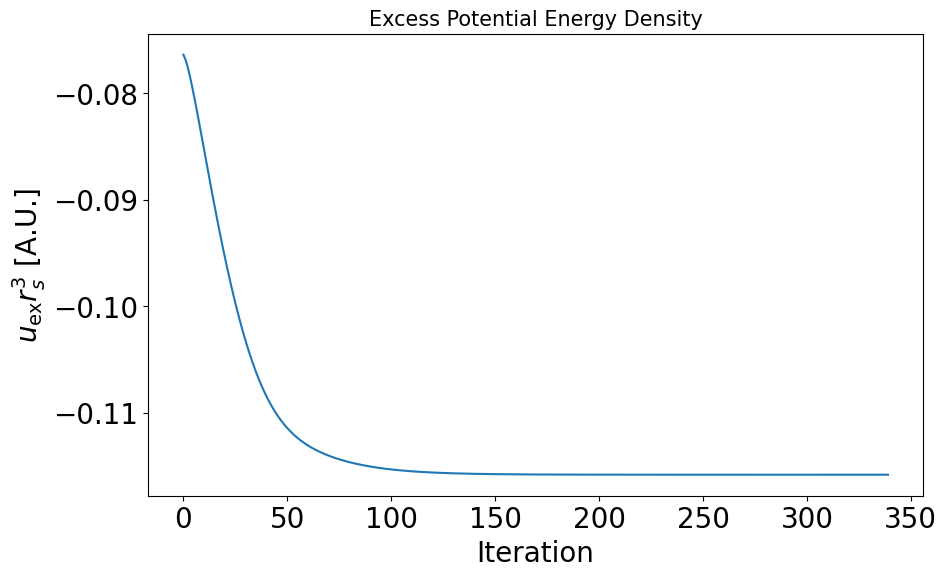

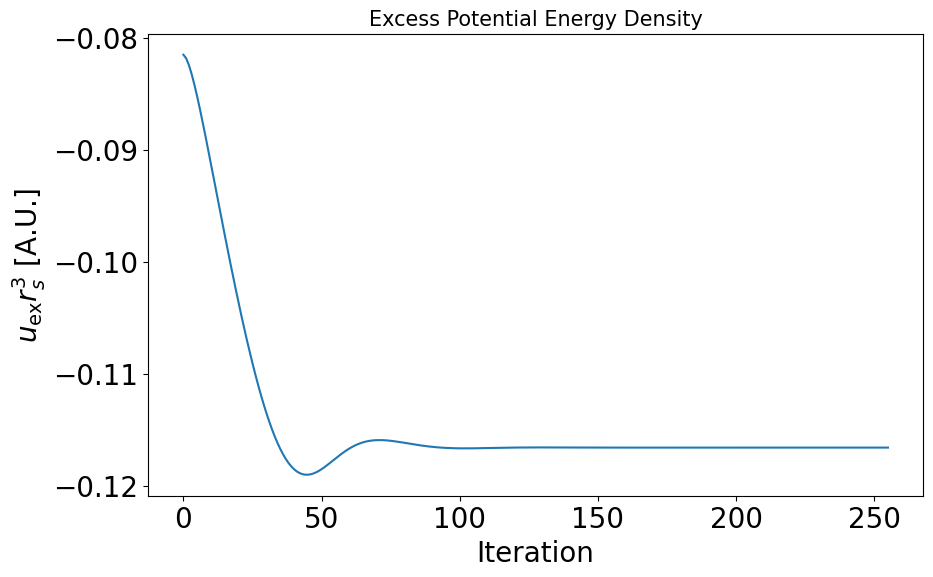

In [225]:
CH1.plot_convergence_uex()
CH1SVT.plot_convergence_uex()

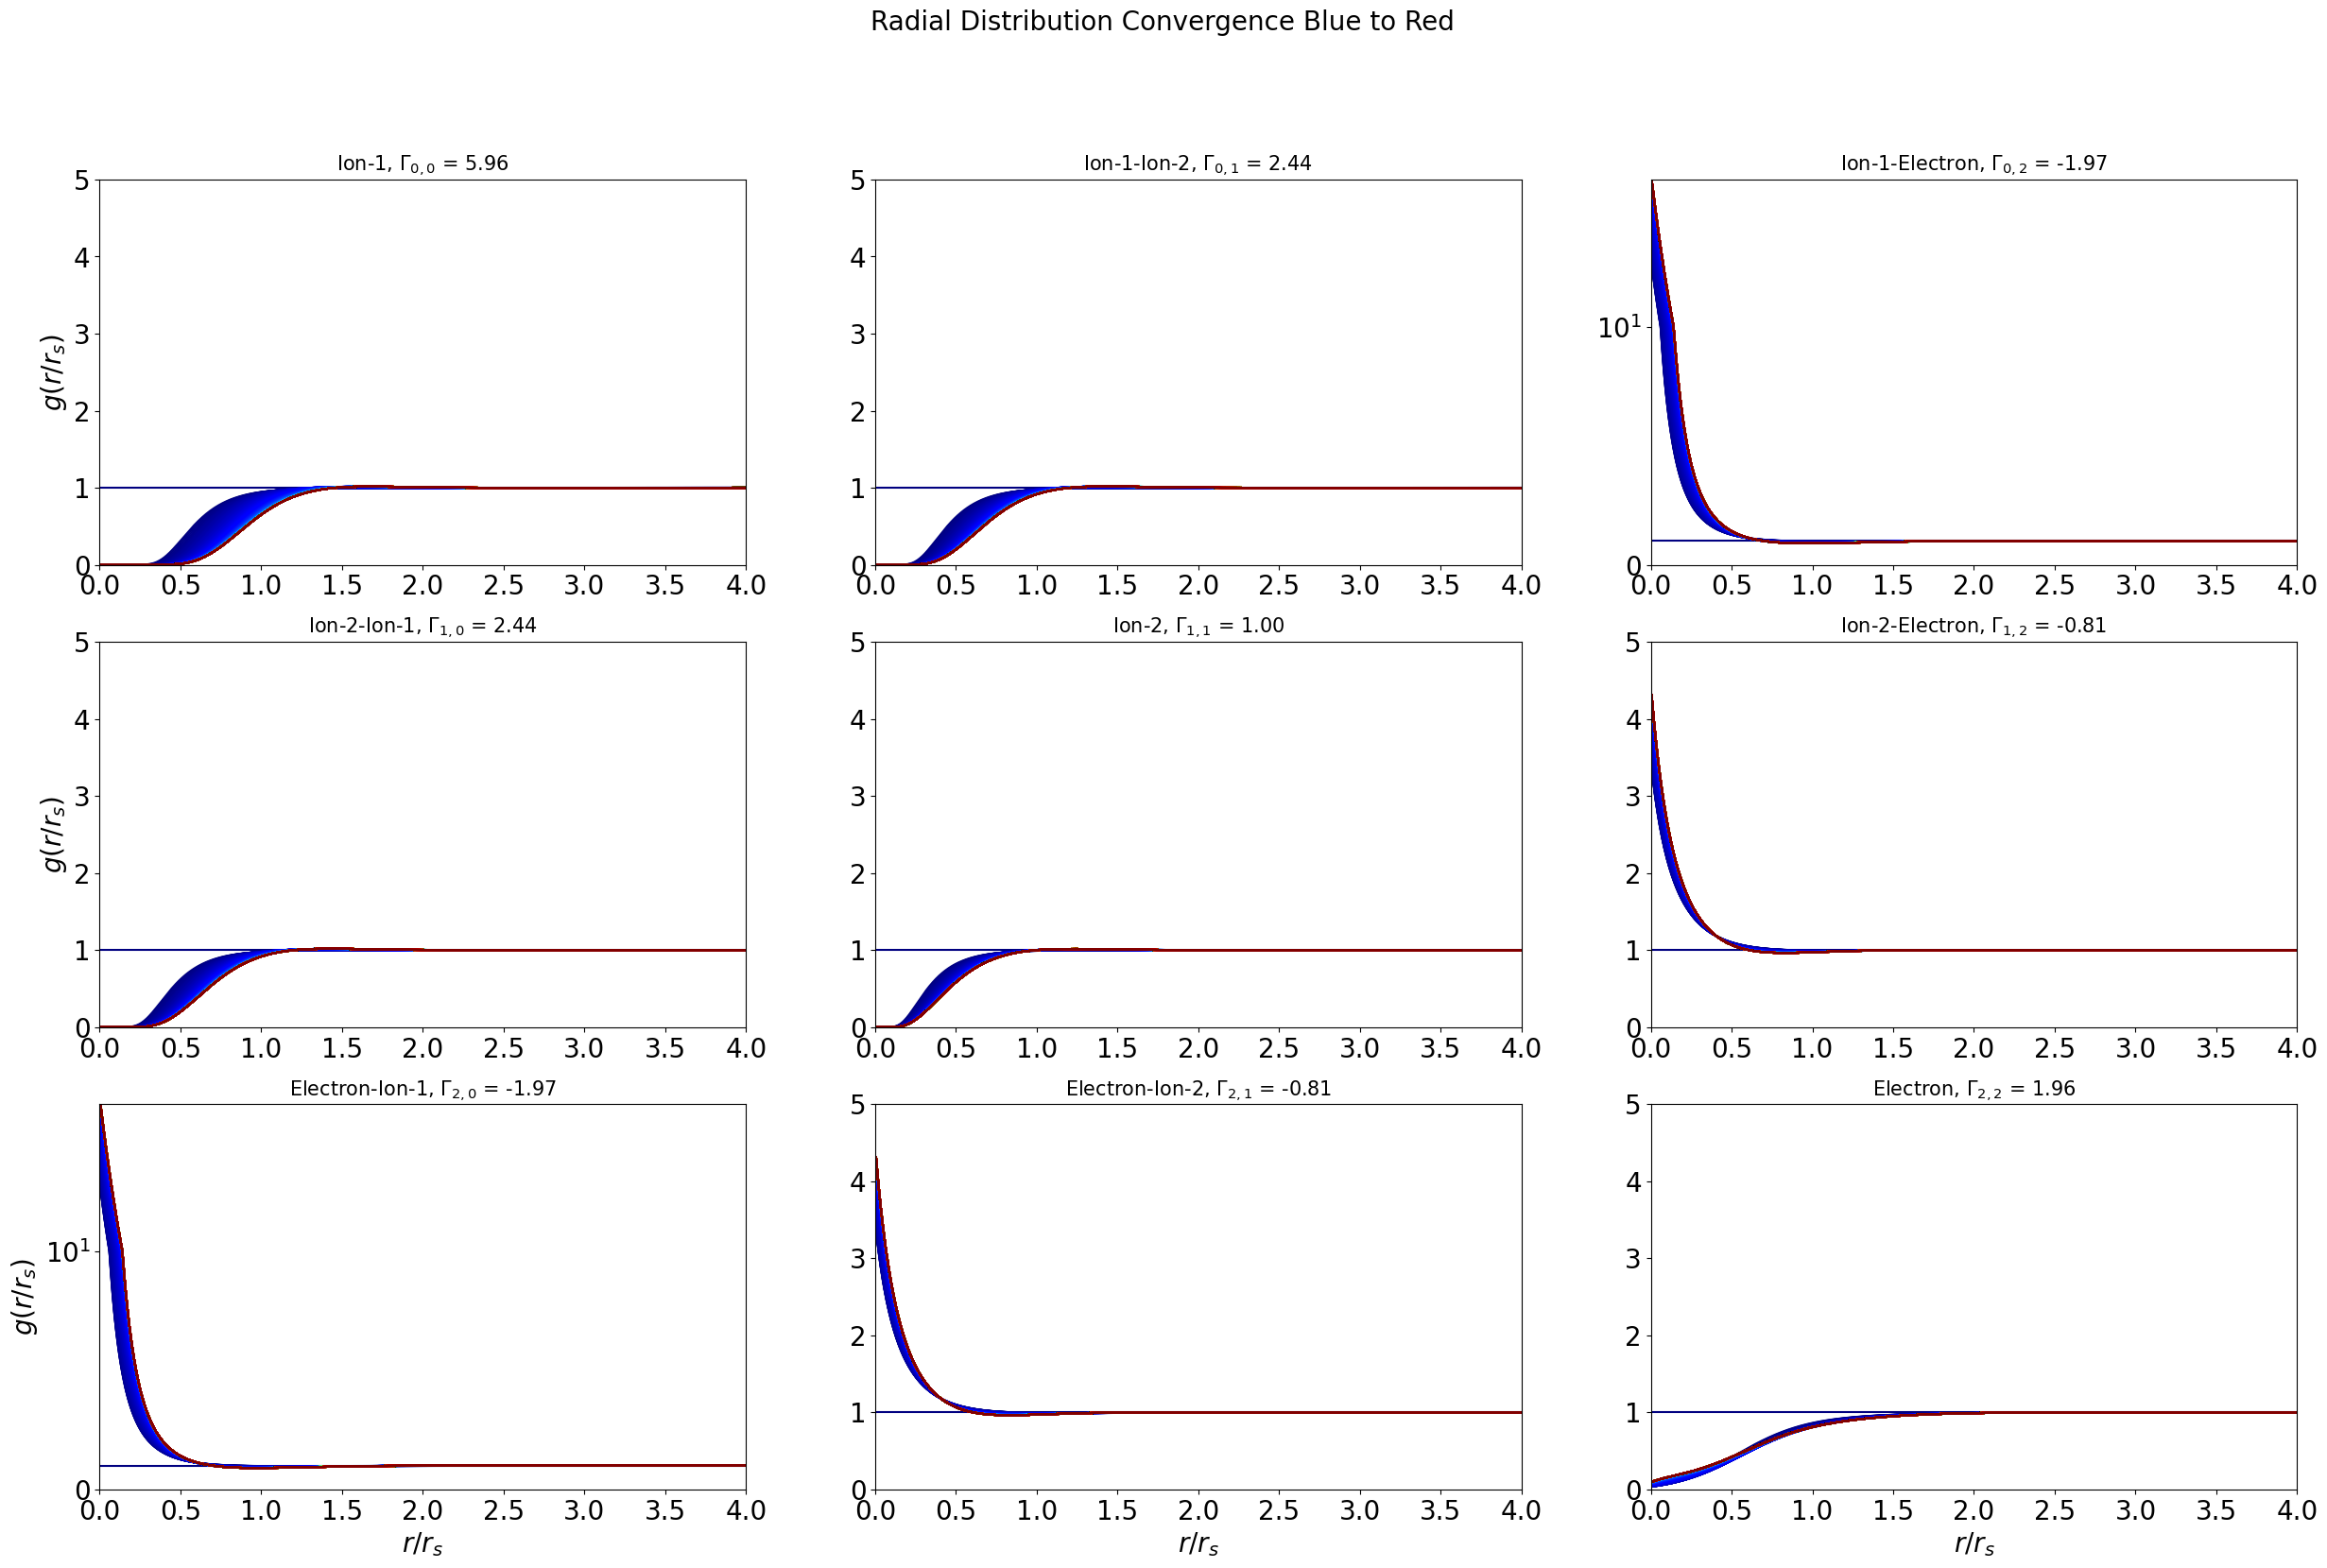

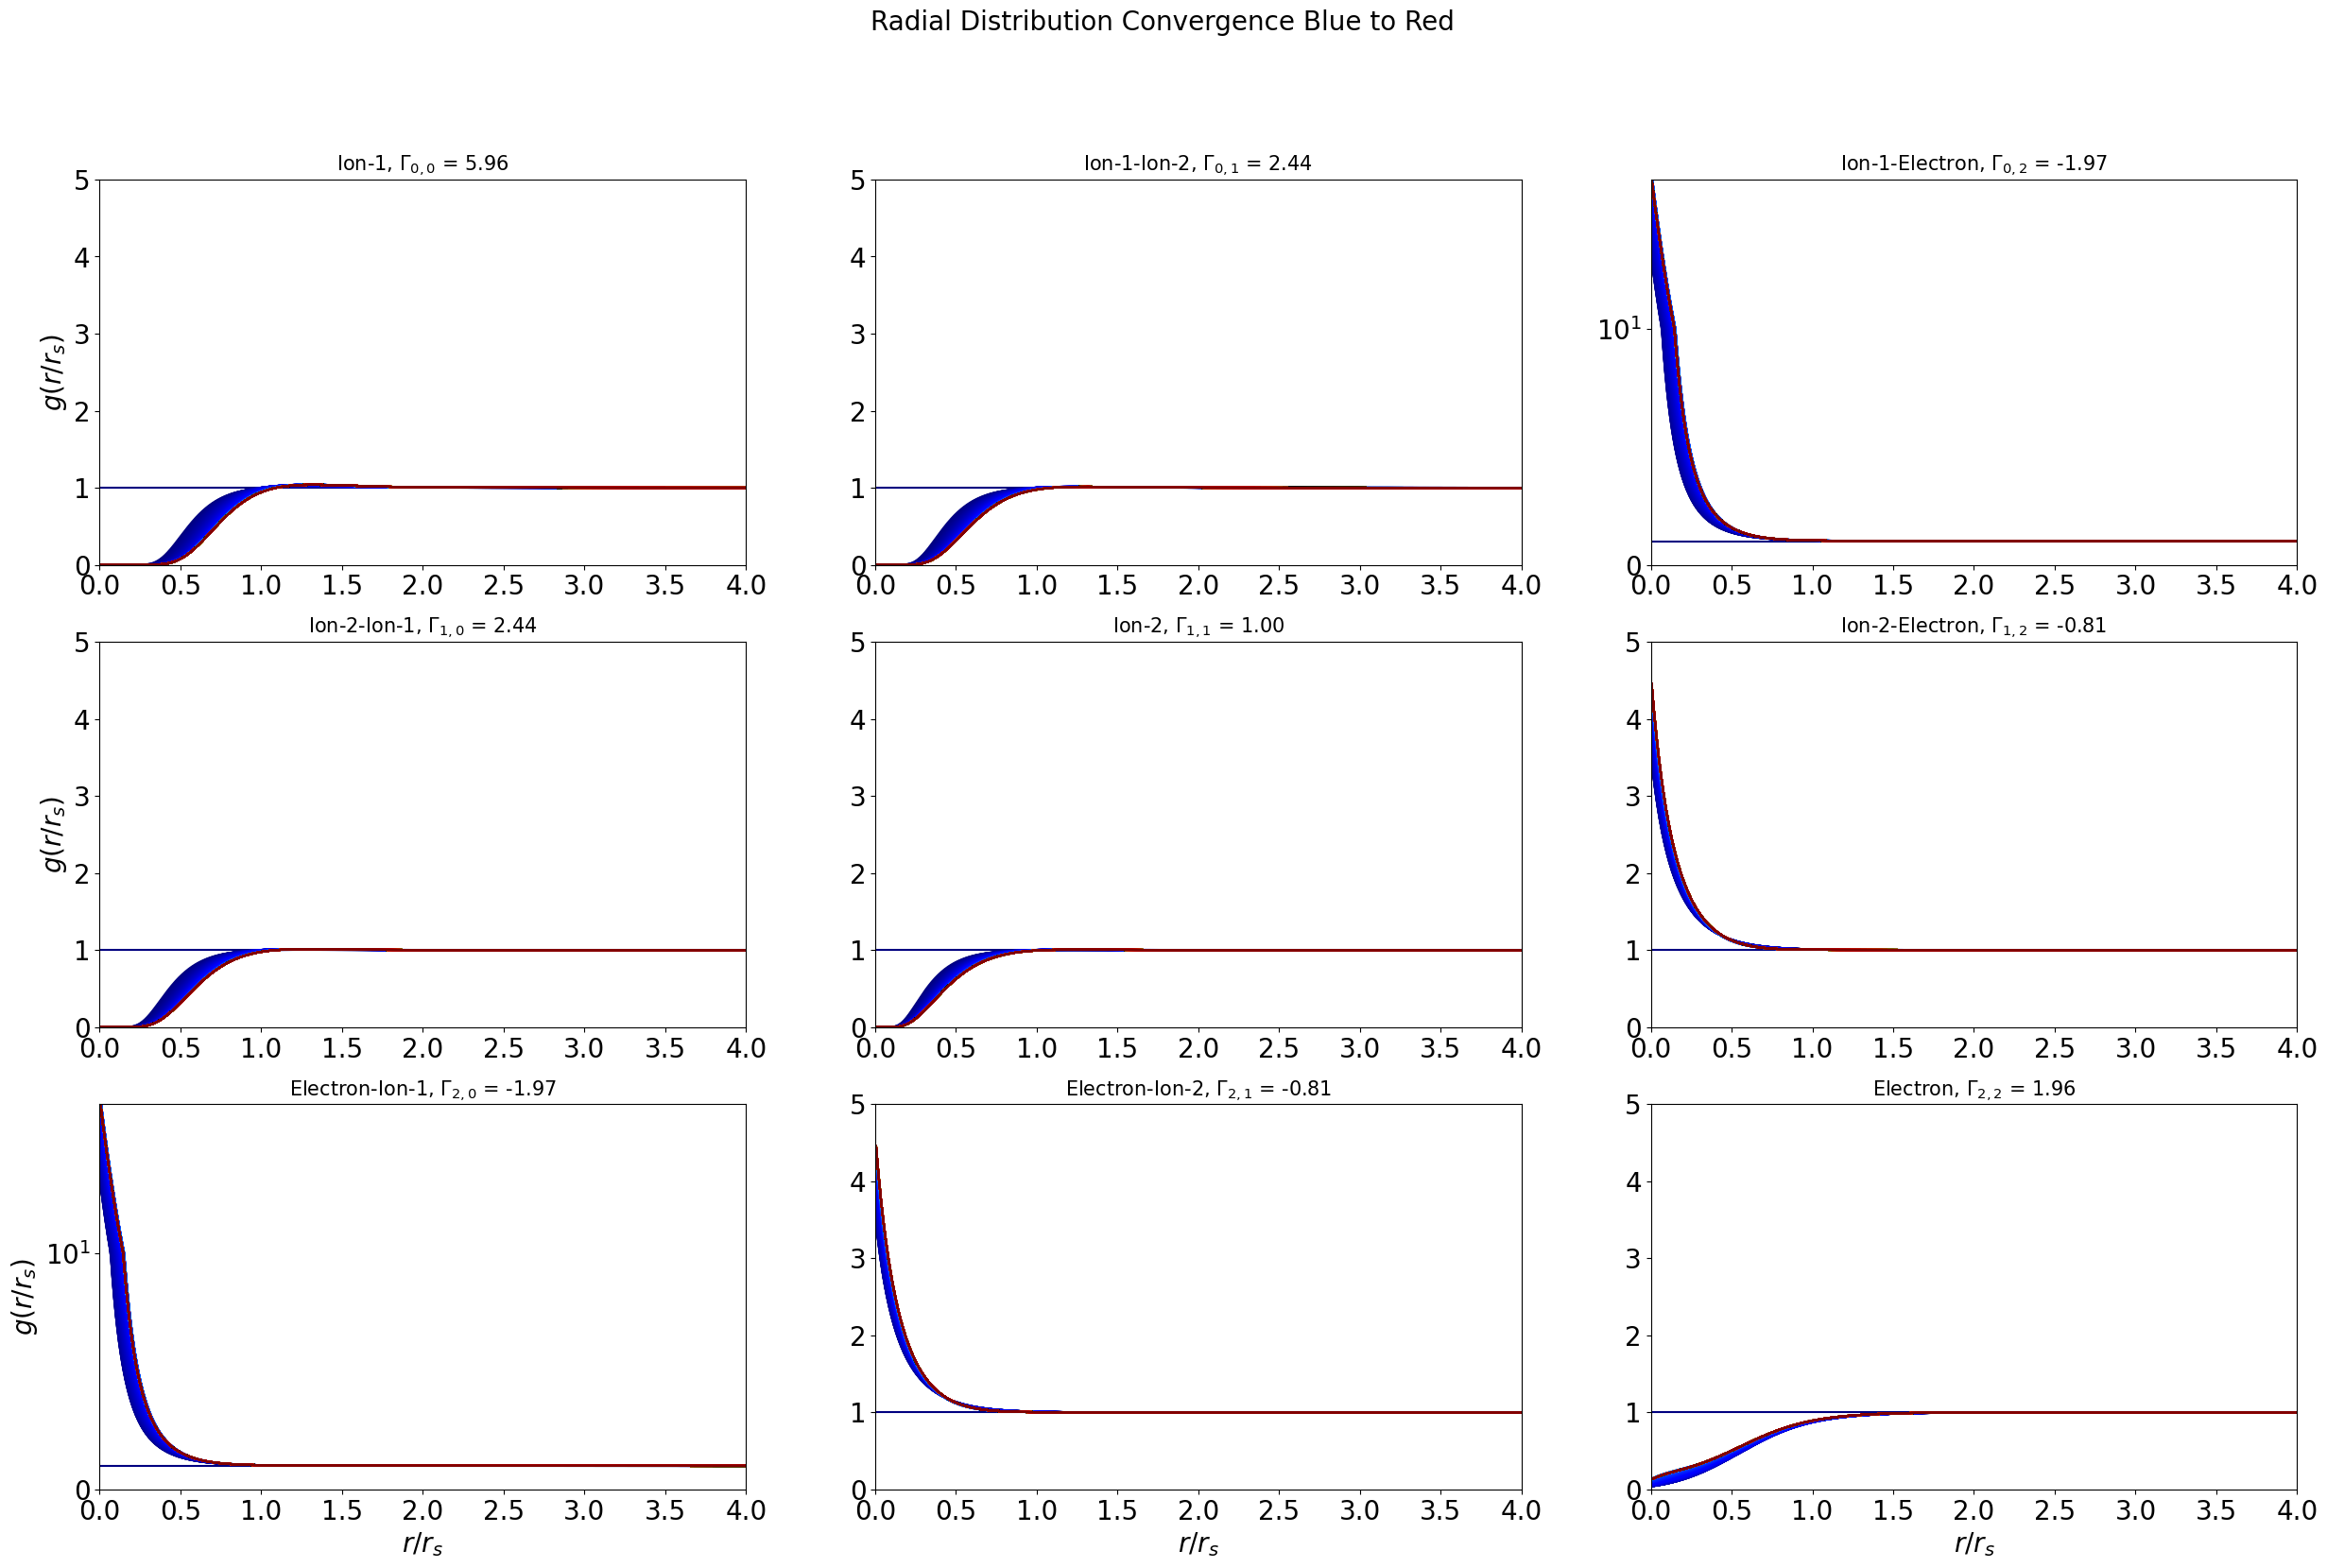

In [226]:
CH1.plot_species_convergence_g(n_slices= int(len(CH1.h_list)/1)  )
CH1SVT.plot_species_convergence_g(n_slices= int(len(CH1.h_list)/1)  )

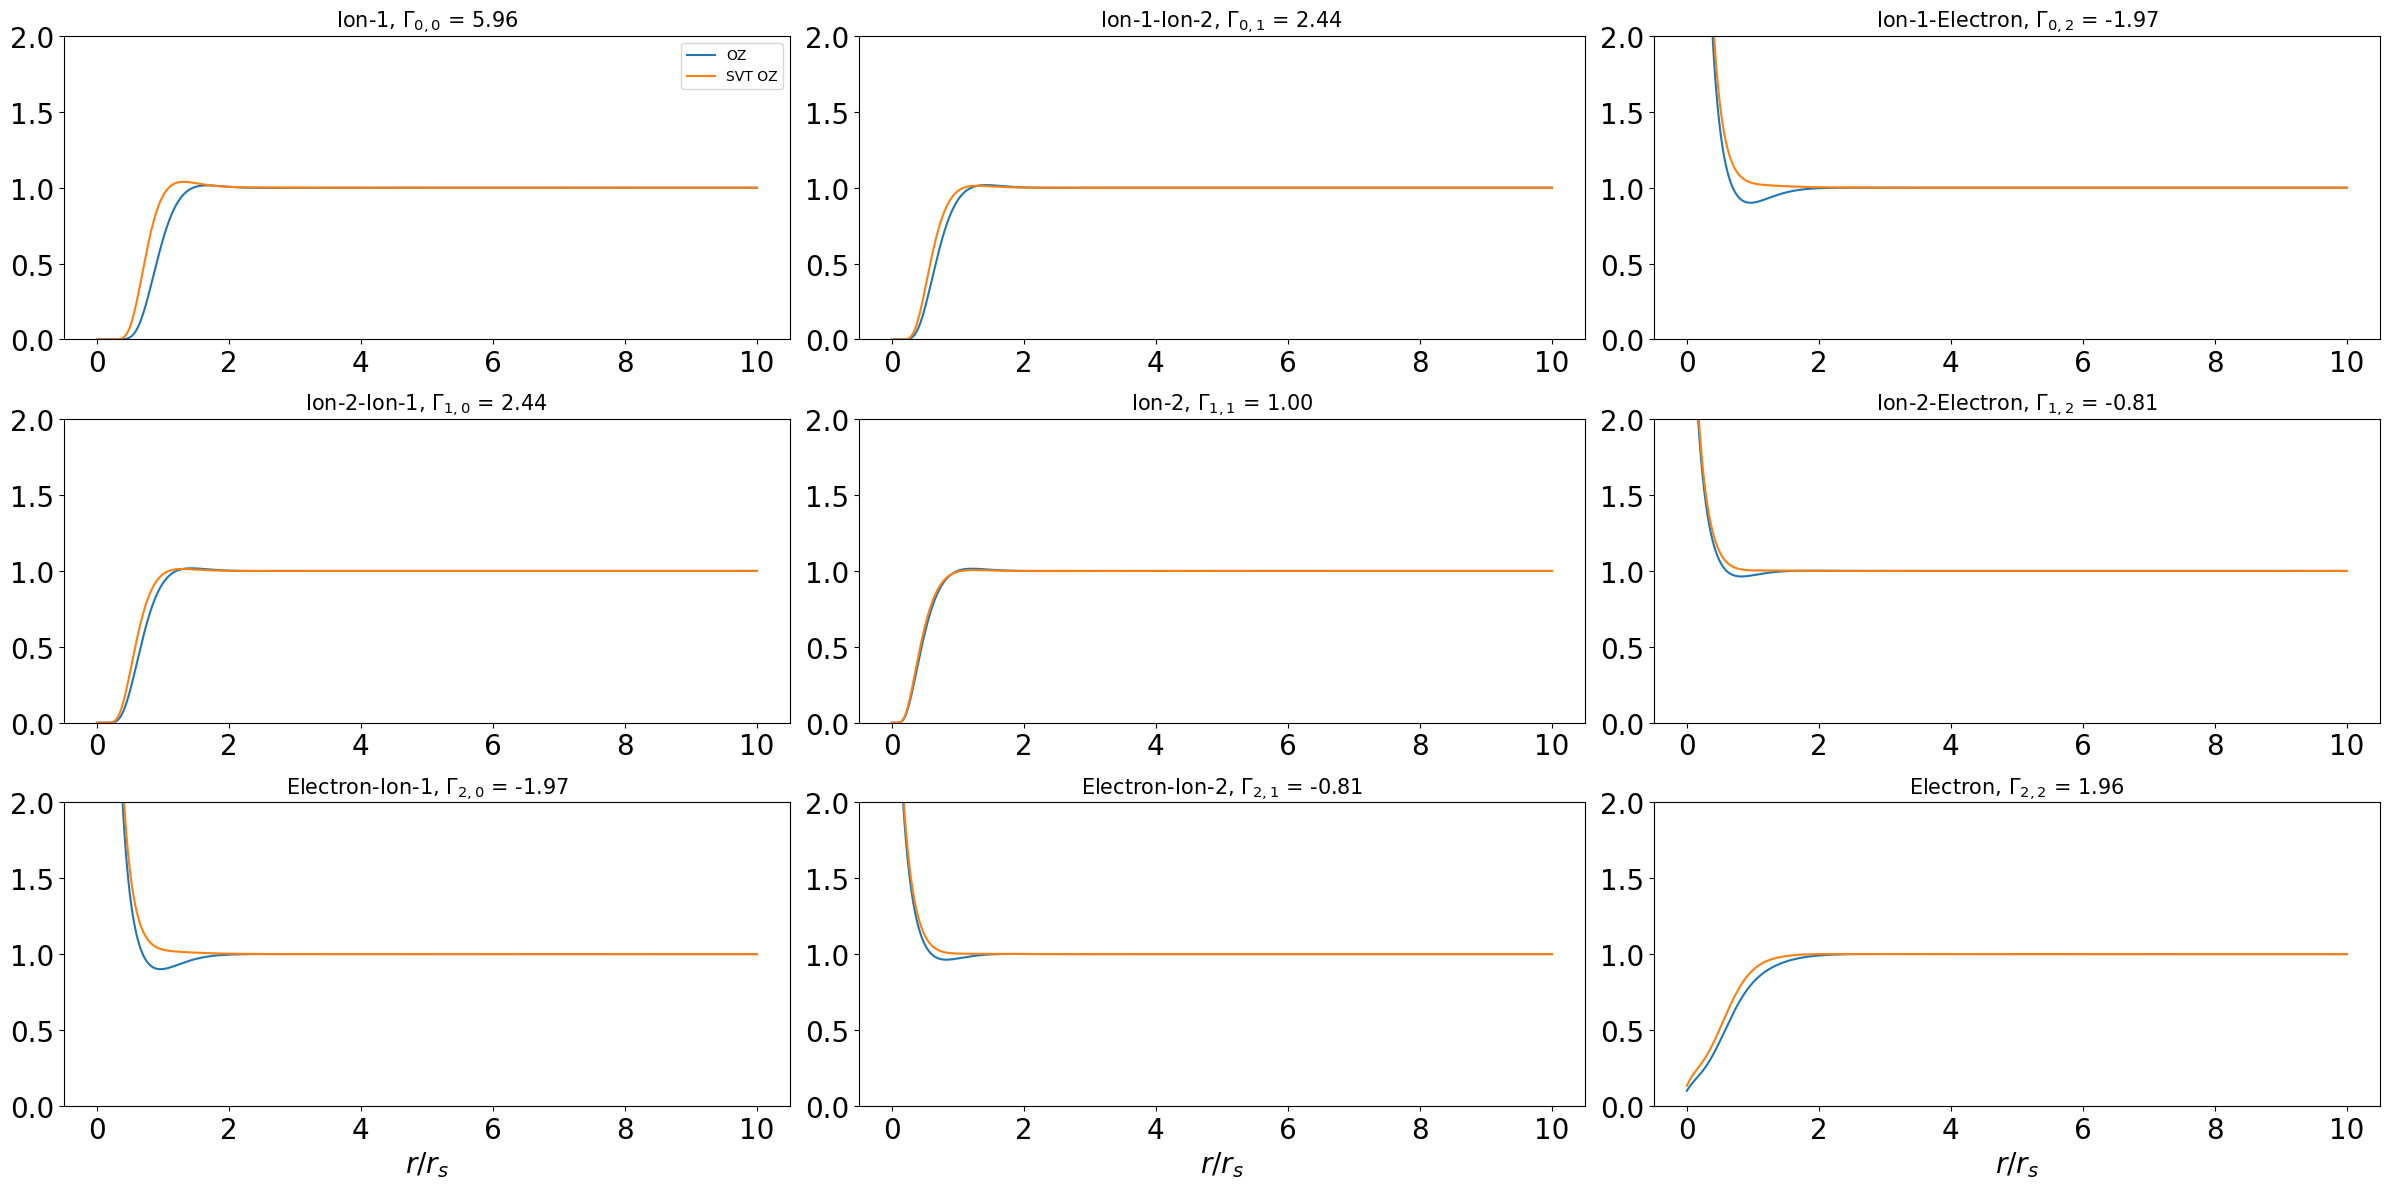

In [228]:
fig, axs = plt.subplots(ncols=CH1.N_species, nrows=CH1.N_species, figsize=(8*CH1.N_species,4*CH1.N_species))

for i in range(CH1.N_species):
            for j in range(CH1.N_species):
                axs[i,j].plot(CH1.r_array, CH1.h_r_matrix[i,j]+1, label='OZ')
                axs[i,j].plot(CH1SVT.r_array, CH1SVT.h_r_matrix[i,j]+1, label='SVT OZ')
                axs[i,j].set_title(CH1.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,CH1.Gamma[i][j]) ,fontsize=15)
                axs[i,j].set_ylim(0,2)
                axs[i,j].tick_params(labelsize=20)
                axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)

axs[0,0].legend()
fig.tight_layout()

### Invert HNC and get βueff

In [229]:
CH1.invert_HNC([2])
CH1SVT.invert_HNC([2])

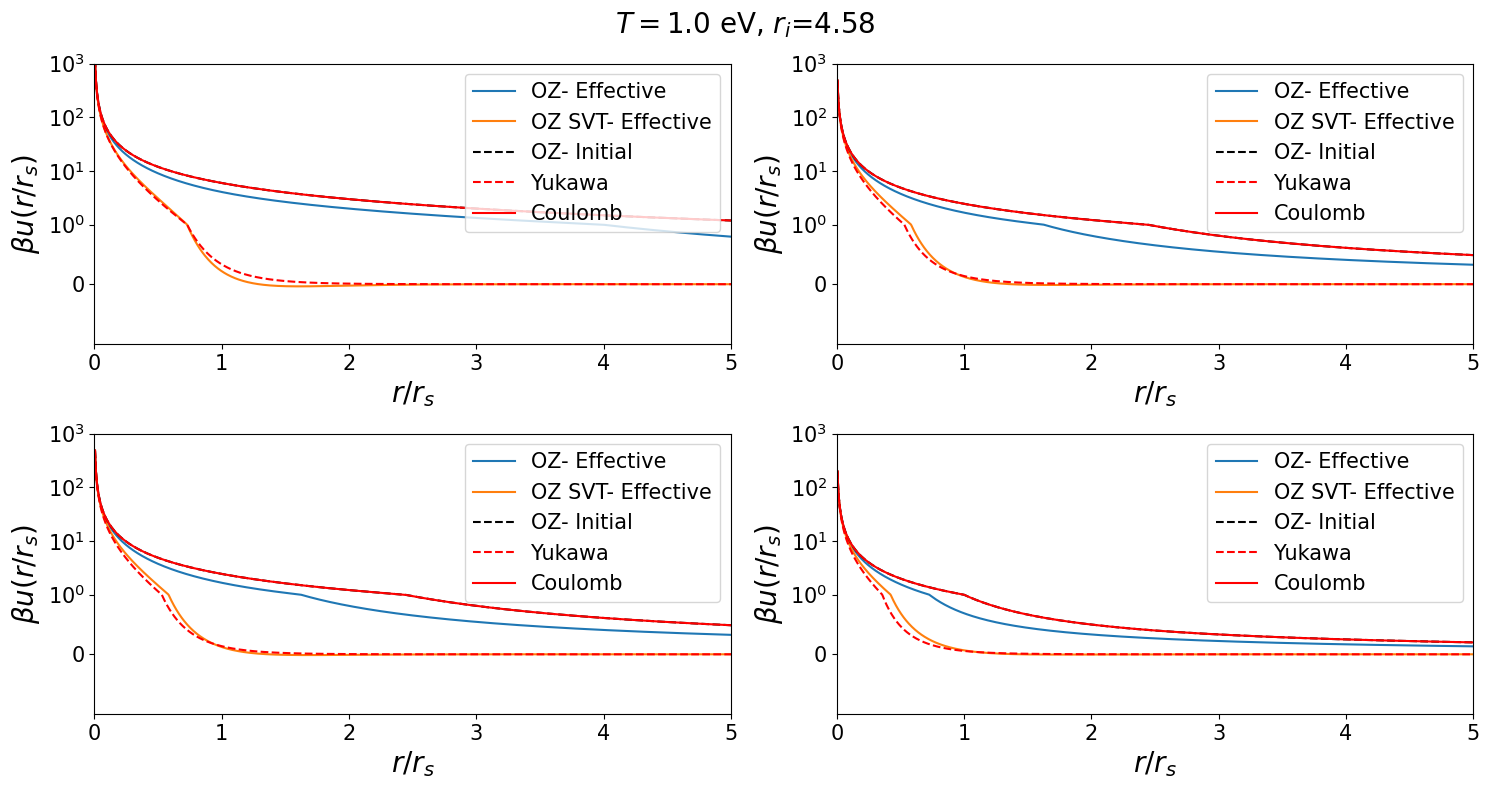

In [230]:
fig, axs = plt.subplots(2,2,figsize=(15,8),facecolor='w')
fig.suptitle(r"$T=${0:.1f} eV, $r_i$={1:.2f}".format(Te/eV,CH1qsp1.ri), fontsize=20)

yukawa_matrix = (CH1.Gamma[:,:,np.newaxis]/CH1.r_array * np.exp(-CH1.r_array*CH1qsp1.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (CH1.Gamma[:,:,np.newaxis]/CH1.r_array) [:-1,:-1]
for i in range(CH1.Neff_species):
            for j in range(CH1.Neff_species):
                axs[i,j].plot(CH1.r_array, CH1.βueff_r_matrix[i,j], label='OZ- Effective')
                axs[i,j].plot(CH1.r_array, CH1SVT.βueff_r_matrix[i,j], label='OZ SVT- Effective')
                axs[i,j].plot(CH1.r_array, CH1.βu_r_matrix[i,j], 'k--',label='OZ- Initial')
                axs[i,j].plot(CH1.r_array, yukawa_matrix[i,j],'r--', label="Yukawa")
                axs[i,j].plot(CH1.r_array, coulomb_matrix[i,j],'r-', label="Coulomb")
                
#                 axs[i,j].plot(CH1SVT.r_array, CH1SVT.h_r_matrix[i,j]+1, label='SVT OZ')
#                 axs[i,j].set_title(CH1.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,CH1.Gamma[i][j]) ,fontsize=15)
                axs[i,j].set_ylim(-1,1e3)
                axs[i,j].tick_params(labelsize=20)
                axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)
                axs[i,j].set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
                axs[i,j].set_xlabel(r'$r/r_s$',fontsize=20)
               
                axs[i,j].set_xlim(0,5)
                axs[i,j].set_yscale('symlog',linthresh=1)
                axs[i,j].tick_params(labelsize=15)
                axs[i,j].legend(fontsize=15)
fig.tight_layout()

In [254]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e4))
        self.y_fit  = func(CH1.r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

In [256]:

def yukawa(r, Γ, κ, p):
    return  Γ/r*np.exp(-κ*r)

def yukawa_remaining(r,a,b,c,d):
    return 1/(a+b*np.exp(c*(r-d)))

def LJ(r, a,b,m,n):
    return  1/(a*r**m + b/r**n) #+ v0

def yukawa_friedel(r, Γ, κ1, a,κ2, k,  δ, v0):
    return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0

def yukawa_plus(r, a ,b ,c, d):
    return a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_gen(r, a ,b ,c, d ,e, f, g, h, i):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g) + h/r

# y_fit = βu_fit(yukawa, CH1.r_array, CH1.βueff_r_matrix[0,0])
# yf_fit = βu_fit(yukawa_friedel, CH1.r_array, CH1.βueff_r_matrix[0,0]) 
# yfg_fit = βu_fit(yukawa_plus_gaussian, CH1.r_array, CH1.βueff_r_matrix[0,0]) 
# ygen_fit = βu_fit(yukawa_gen, CH1.r_array, CH1.βueff_r_matrix[0,0]) 


SVTy_fit = βu_fit(yukawa, CH1SVT.r_array, CH1SVT.βueff_r_matrix[0,0])
SVTyf_fit = βu_fit(yukawa_friedel, CH1SVT.r_array, CH1SVT.βueff_r_matrix[0,0]) 
SVTyp_fit = βu_fit(yukawa_plus, CH1SVT.r_array, CH1SVT.βueff_r_matrix[0,0])
SVTypg_fit = βu_fit(yukawa_plus_gaussian, CH1SVT.r_array, CH1SVT.βueff_r_matrix[0,0])
SVTygen_fit = βu_fit(yukawa_gen, CH1SVT.r_array, CH1SVT.βueff_r_matrix[0,0])

# SVTyukawa_friedel_fit = βu_fit(yukawa_friedel, CH1SVT.r_array, CH1SVT.βueff_r_matrix[0,0]) 

# y_vals = curve_fit(yukawa_fit, CH1.r_array, CH1.βueff_r_matrix[0,0])
# y_fit_data  = yukawa_fit(CH1.r_array, **y_vals[0])

# y_remaining_vals = curve_fit(yukawa_remaining_fit, CH1.r_array, CH1.βueff_r_matrix[0,0]/y_fit_data)
# y_remaining_fit_data  = yukawa_remaining_fit(CH1.r_array, y_remaining_vals[0][0],y_remaining_vals[0][1],y_remaining_vals[0][2],y_remaining_vals[0][3])

# yf_vals = curve_fit(yukawa_friedel_fit, CH1.r_array, CH1.βueff_r_matrix[0,0])
# yf_fit_data  = yukawa_friedel_fit(CH1.r_array, y_vals[0][0], y_vals[0][1], y_vals[0][2])


yukawa error: 2.714e+00 
yukawa_friedel error: 2.057e+00 
yukawa_plus error: 2.714e+00 
yukawa_plus_gaussian error: 1.467e+00 
yukawa_gen error: 1.016e+00 


/tmp/ipykernel_16533/2673406072.py:11: RuntimeWarning: overflow encountered in exp
  return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0
/tmp/ipykernel_16533/2673406072.py:11: RuntimeWarning: overflow encountered in multiply
  return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0
/tmp/ipykernel_16533/2673406072.py:17: RuntimeWarning: overflow encountered in exp
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)
/tmp/ipykernel_16533/2673406072.py:20: RuntimeWarning: overflow encountered in exp
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g) + h/r


In [257]:
SVTyp_fit.err

2.713639523718456

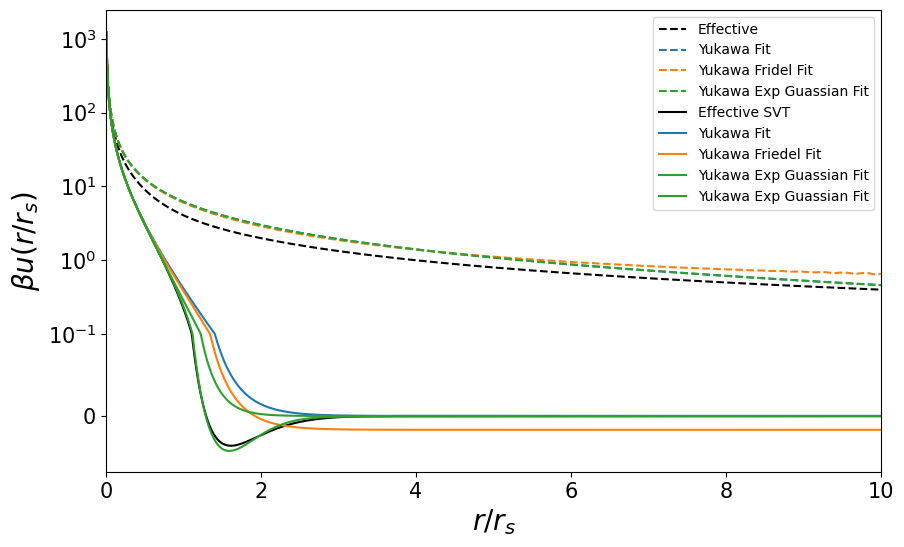

In [242]:
fig, ax = plt.subplots(figsize=(10,6))


g_data = CH1.h_r_matrix[0,0] + 1

ax.plot(CH1.r_array, CH1.βueff_r_matrix[0,0],'k--', label="Effective")
ax.plot(yukawa_fit.r, yukawa_fit.y_fit,color=colors[0], linestyle='--', label="Yukawa Fit")
ax.plot(yukawa_fit.r, yukawa_friedel_fit.y_fit,color=colors[1], linestyle='--', label="Yukawa Fridel Fit")
ax.plot(yukawa_fit.r, yfg_fit.y_fit,color=colors[2], linestyle='--', label="Yukawa Exp Guassian Fit")
# ax.plot(yukawa_fit.r, yfpg_fit.y_fit,color=colors[3], linestyle='--', label="Yukawa Exp c Guassian Fit")

ax.plot(CH1.r_array, CH1SVT.βueff_r_matrix[0,0],'k-', label="Effective SVT")
ax.plot(yukawa_fit.r, SVTy_fit.y_fit,color=colors[0], linestyle='-', label="Yukawa Fit")
ax.plot(yukawa_fit.r, SVTyf_fit.y_fit,color=colors[1],linestyle='-', label="Yukawa Friedel Fit")
ax.plot(yukawa_fit.r, SVTypg_fit.y_fit,color=colors[2],linestyle='-', label="Yukawa Exp Guassian Fit")
ax.plot(yukawa_fit.r, SVTygen_fit.y_fit,color=colors[2],linestyle='-', label="Yukawa Exp Guassian Fit")

ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-0.1,0.1)
ax.set_yscale('symlog',linthresh=1e-1)
ax.set_xlim(0e-2,10)
# ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)

## Copper

In [9]:
ni = 8.49e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 29,63.55
Zstar= 1.206


copper,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='fixed', alpha=0.1)

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
0: Err in c_r: 5.54e+00, OZ: 1.49e-01, HNC: 5.17e+00, tot: 0.44
1: Err in c_r: 5.02e+00, OZ: 1.46e-01, HNC: 3.59e+00, tot: 0.43
2: Err in c_r: 4.54e+00, OZ: 1.43e-01, HNC: 2.69e+00, tot: 0.43
3: Err in c_r: 4.11e+00, OZ: 1.40e-01, HNC: 2.14e+00, tot: 0.44
4: Err in c_r: 3.72e+00, OZ: 1.38e-01, HNC: 1.78e+00, tot: 0.44
5: Err in c_r: 3.37e+00, OZ: 1.35e-01, HNC: 1.55e+00, tot: 0.45
6: Err in c_r: 3.05e+00, OZ: 1.33e-01, HNC: 1.39e+00, tot: 0.46
7: Err in c_r: 2.76e+00, OZ: 1.30e-01, HNC: 1.28e+00, tot: 0.46
8: Err in c_r: 2.50e+00, OZ: 1.28e-01, HNC: 1.20e+00, tot: 0.47
9: Err in c_r: 2.26e+00, OZ: 1.26e-01, HNC: 1.16e+00, tot: 0.48
10: Err in c_r: 2.05e+00, OZ: 1.24e-01, HNC: 1.13e+00, tot: 0.49
11: Err in c_r: 1.85e+00, OZ: 1.22e-01, HNC: 1.13e+00, tot: 0.50
12: Err in c_r: 1.68e+00, OZ: 1.20e-01, HNC: 1.13e+00, tot: 0.52
13: Err in c_r: 1.52e+00, OZ: 1.18e-01, HNC: 1.15e+00, tot: 0.53
14: Err 

135: Err in c_r: 3.75e-03, OZ: 1.27e-02, HNC: 2.68e-01, tot: 1.49
136: Err in c_r: 3.66e-03, OZ: 1.24e-02, HNC: 2.62e-01, tot: 1.49
137: Err in c_r: 3.58e-03, OZ: 1.22e-02, HNC: 2.55e-01, tot: 1.49
138: Err in c_r: 3.49e-03, OZ: 1.19e-02, HNC: 2.49e-01, tot: 1.49
139: Err in c_r: 3.41e-03, OZ: 1.17e-02, HNC: 2.43e-01, tot: 1.49
140: Err in c_r: 3.33e-03, OZ: 1.14e-02, HNC: 2.37e-01, tot: 1.50
141: Err in c_r: 3.25e-03, OZ: 1.12e-02, HNC: 2.31e-01, tot: 1.50
142: Err in c_r: 3.18e-03, OZ: 1.09e-02, HNC: 2.25e-01, tot: 1.50
143: Err in c_r: 3.11e-03, OZ: 1.07e-02, HNC: 2.20e-01, tot: 1.50
144: Err in c_r: 3.03e-03, OZ: 1.05e-02, HNC: 2.14e-01, tot: 1.50
145: Err in c_r: 2.96e-03, OZ: 1.03e-02, HNC: 2.09e-01, tot: 1.50
146: Err in c_r: 2.89e-03, OZ: 1.00e-02, HNC: 2.04e-01, tot: 1.50
147: Err in c_r: 2.83e-03, OZ: 9.82e-03, HNC: 1.99e-01, tot: 1.50
148: Err in c_r: 2.76e-03, OZ: 9.61e-03, HNC: 1.94e-01, tot: 1.50
149: Err in c_r: 2.70e-03, OZ: 9.41e-03, HNC: 1.89e-01, tot: 1.51
150: Err i

274: Err in c_r: 1.61e-04, OZ: 6.05e-04, HNC: 1.08e-02, tot: 1.55
275: Err in c_r: 1.57e-04, OZ: 5.92e-04, HNC: 1.06e-02, tot: 1.55
276: Err in c_r: 1.54e-04, OZ: 5.79e-04, HNC: 1.03e-02, tot: 1.55
277: Err in c_r: 1.50e-04, OZ: 5.66e-04, HNC: 1.01e-02, tot: 1.55
278: Err in c_r: 1.47e-04, OZ: 5.54e-04, HNC: 9.88e-03, tot: 1.55
279: Err in c_r: 1.44e-04, OZ: 5.42e-04, HNC: 9.67e-03, tot: 1.55
280: Err in c_r: 1.41e-04, OZ: 5.30e-04, HNC: 9.45e-03, tot: 1.55
281: Err in c_r: 1.38e-04, OZ: 5.18e-04, HNC: 9.24e-03, tot: 1.55
282: Err in c_r: 1.35e-04, OZ: 5.07e-04, HNC: 9.04e-03, tot: 1.55
283: Err in c_r: 1.32e-04, OZ: 4.96e-04, HNC: 8.84e-03, tot: 1.55
284: Err in c_r: 1.29e-04, OZ: 4.85e-04, HNC: 8.65e-03, tot: 1.55
285: Err in c_r: 1.26e-04, OZ: 4.74e-04, HNC: 8.46e-03, tot: 1.55
286: Err in c_r: 1.23e-04, OZ: 4.64e-04, HNC: 8.27e-03, tot: 1.55
287: Err in c_r: 1.20e-04, OZ: 4.54e-04, HNC: 8.09e-03, tot: 1.55
288: Err in c_r: 1.18e-04, OZ: 4.44e-04, HNC: 7.91e-03, tot: 1.55
289: Err i

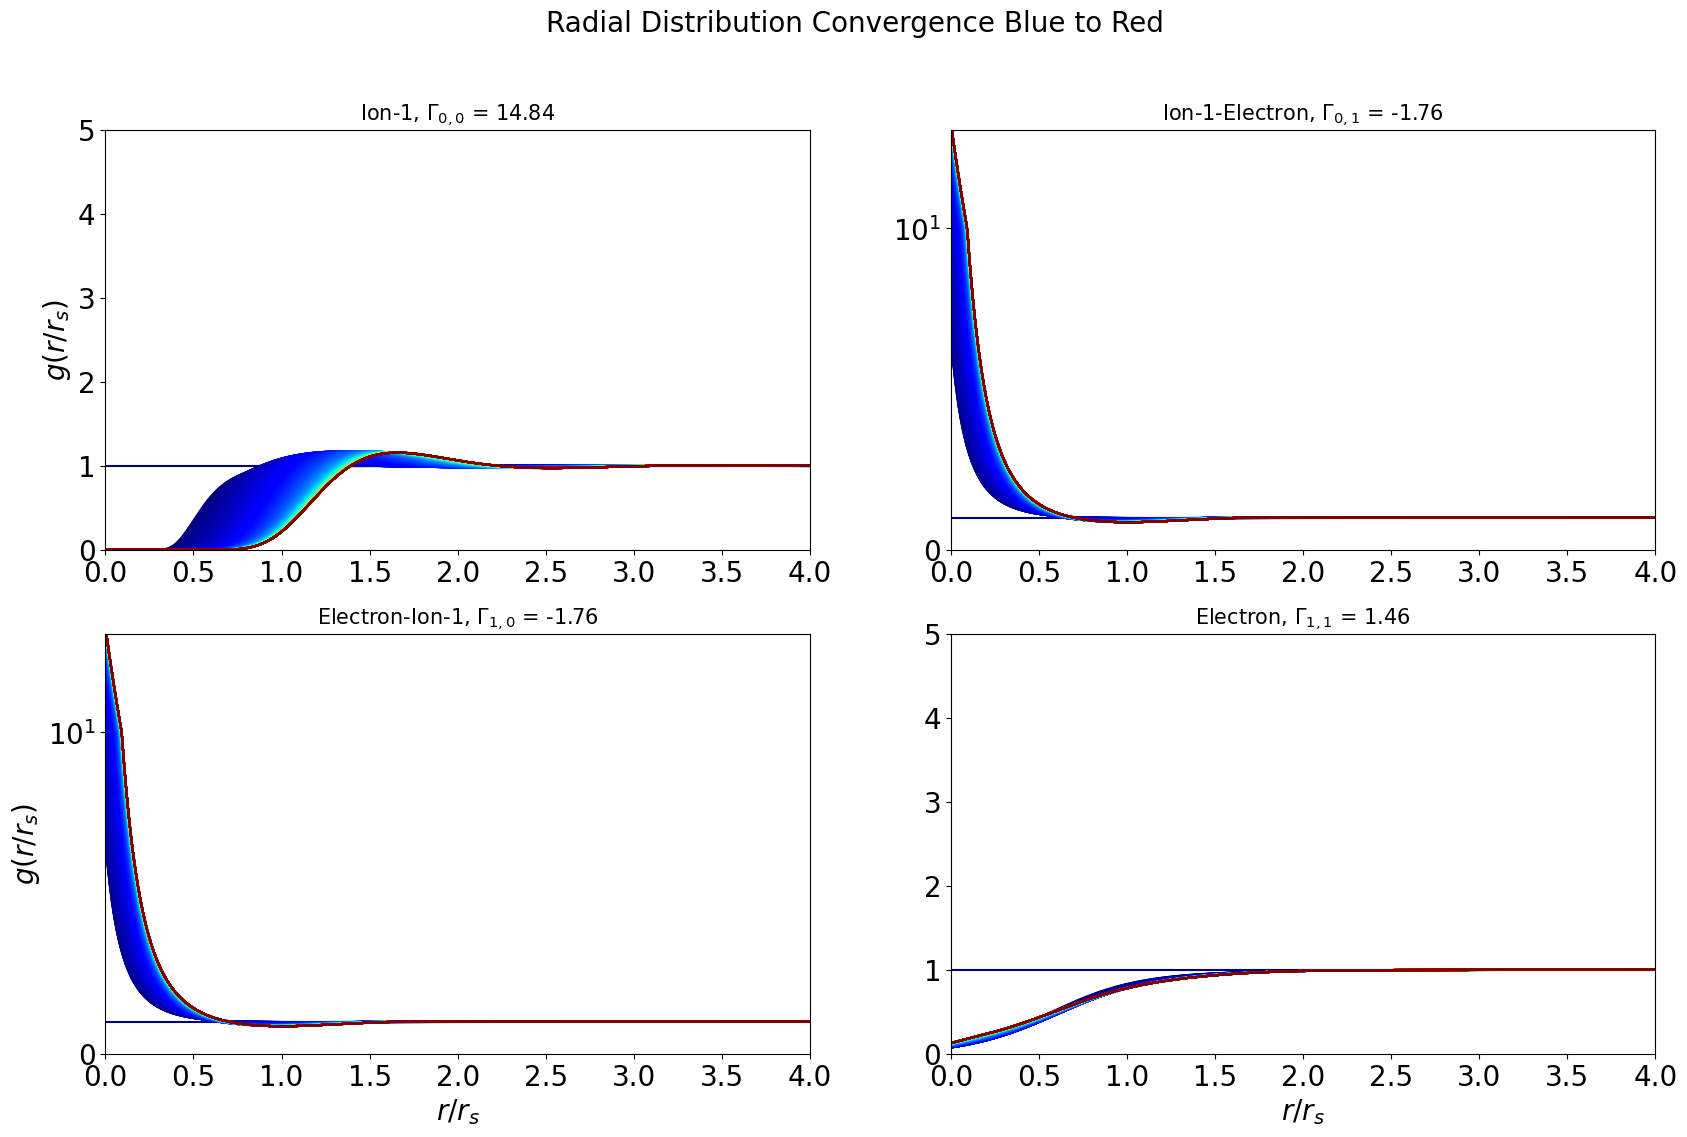

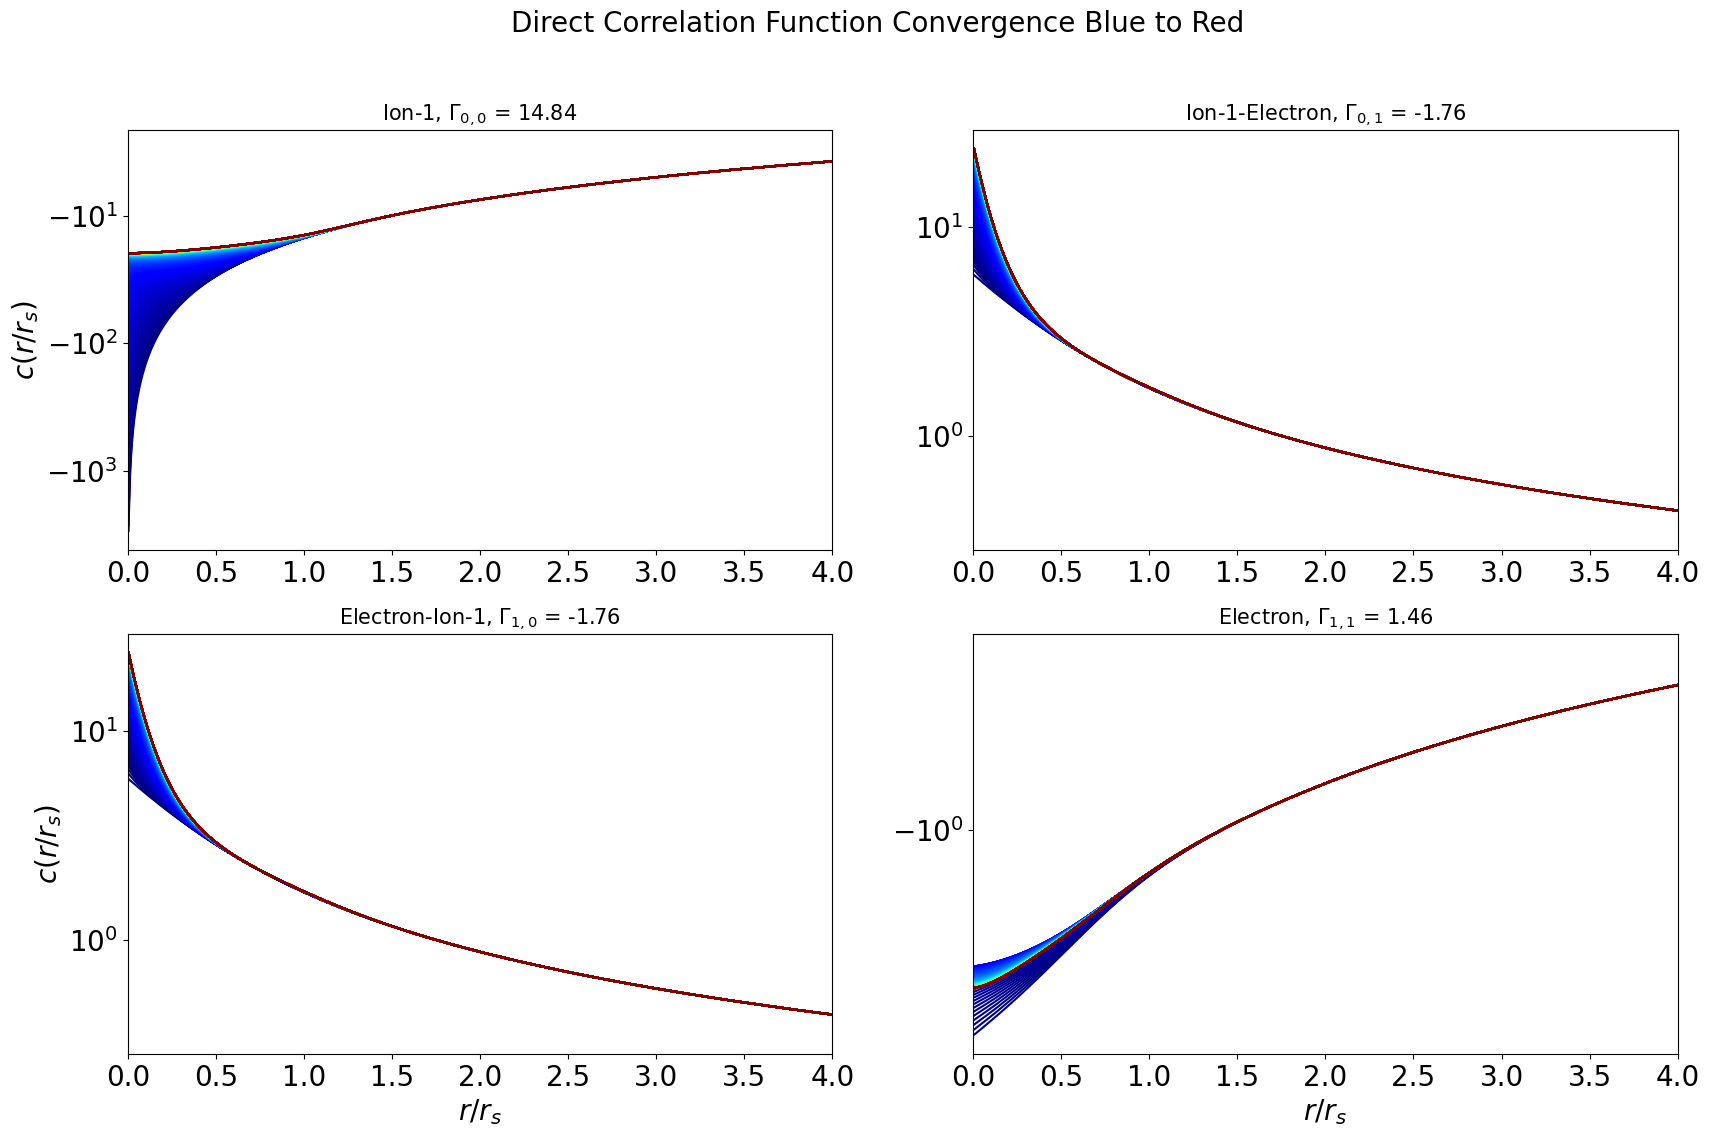

In [10]:
copper.plot_species_convergence_g(n_slices= int(len(copper.h_list)/1)  )
copper.plot_species_convergence_c(n_slices= int(len(copper.h_list)/1)  )

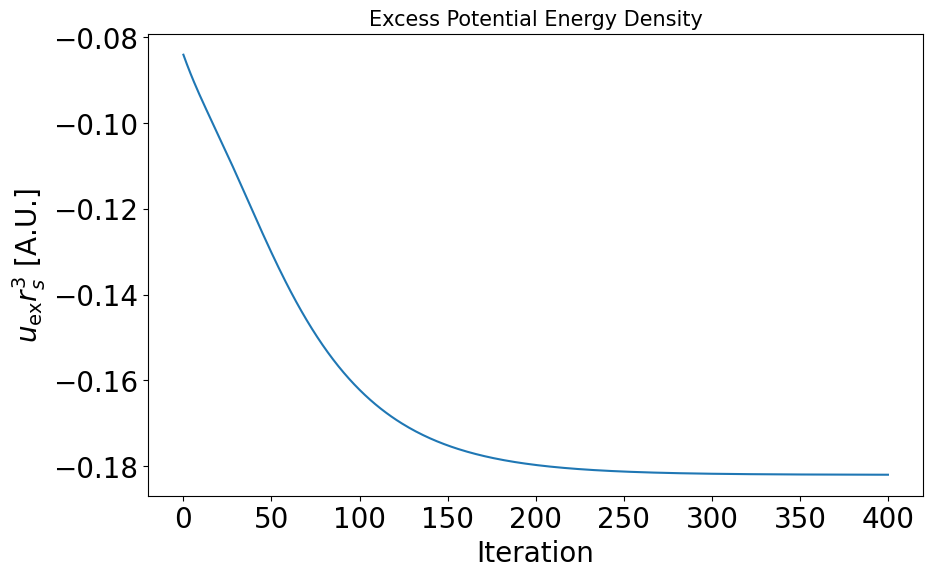

In [11]:
copper.plot_convergence_uex()

In [26]:
copper_one_species,_ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00313886] True Optimization terminated successfully.
0: Err in c_r: 5.56e+01, OZ: 1.54e-01, HNC: 1.60e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 2.90e+01, OZ: 1.45e-01, HNC: 1.15e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 1.52e+01, OZ: 1.34e-01, HNC: 9.94e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 8.05e+00, OZ: 1.25e-01, HNC: 9.62e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 4.34e+00, OZ: 1.17e-01, HNC: 9.65e-03
 HNC min: [0.5] True Optimization terminated succe

 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.06e-03, OZ: 9.59e-04, HNC: 9.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.85e-03, OZ: 8.61e-04, HNC: 8.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.66e-03, OZ: 7.72e-04, HNC: 7.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.49e-03, OZ: 6.93e-04, HNC: 7.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.34e-03, OZ: 6.22e-04, HNC: 6.29e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
57: Err in c_r: 1.20e-03, OZ: 5.58e-04, HNC: 5.65e-05
 HNC min: [0.5] True Optimization

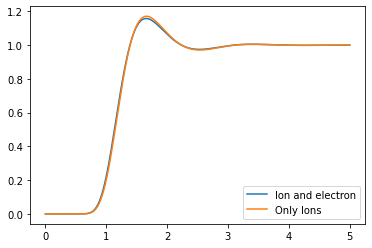

In [27]:
fig, ax = plt.subplots()

ax.plot(copper.r_array, copper.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(copper.r_array, copper_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Hydrogen

In [15]:
ni = 5.98e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 1,1
Zstar= 1
hydrogen, _ = run_hnc(ni, Te, Z, A, Zstar ,method='fixed',alpha=0.1)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 3.70e+00, OZ: 1.25e-01, HNC: 1.26e-01, tot: 0.25
1: Err in c_r: 3.34e+00, OZ: 1.22e-01, HNC: 1.13e-01, tot: 0.26
2: Err in c_r: 3.02e+00, OZ: 1.20e-01, HNC: 1.03e-01, tot: 0.26
3: Err in c_r: 2.73e+00, OZ: 1.17e-01, HNC: 9.42e-02, tot: 0.26
4: Err in c_r: 2.47e+00, OZ: 1.14e-01, HNC: 8.73e-02, tot: 0.27
5: Err in c_r: 2.24e+00, OZ: 1.11e-01, HNC: 8.17e-02, tot: 0.27
6: Err in c_r: 2.02e+00, OZ: 1.09e-01, HNC: 7.70e-02, tot: 0.27
7: Err in c_r: 1.83e+00, OZ: 1.07e-01, HNC: 7.32e-02, tot: 0.28
8: Err in c_r: 1.65e+00, OZ: 1.04e-01, HNC: 7.00e-02, tot: 0.28
9: Err in c_r: 1.49e+00, OZ: 1.02e-01, HNC: 6.74e-02, tot: 0.28
10: Err in c_r: 1.35e+00, OZ: 9.98e-02, HNC: 6.52e-02, tot: 0.28
11: Err in c_r: 1.22e+00, OZ: 9.77e-02, HNC: 6.35e-02, tot: 0.29
12: Err in c_r: 1.10e+00, OZ: 9.56e-02, HNC: 6.21e-02, tot: 0.29
13: Err in c_r: 9.99e-01, OZ: 9.36e-02, HNC: 6.10e-02, tot: 0.29
14: Err i

135: Err in c_r: 1.25e-03, OZ: 4.69e-03, HNC: 4.09e-03, tot: 0.43
136: Err in c_r: 1.21e-03, OZ: 4.56e-03, HNC: 3.98e-03, tot: 0.43
137: Err in c_r: 1.18e-03, OZ: 4.44e-03, HNC: 3.87e-03, tot: 0.43
138: Err in c_r: 1.14e-03, OZ: 4.32e-03, HNC: 3.76e-03, tot: 0.43
139: Err in c_r: 1.11e-03, OZ: 4.20e-03, HNC: 3.66e-03, tot: 0.43
140: Err in c_r: 1.08e-03, OZ: 4.09e-03, HNC: 3.56e-03, tot: 0.43
141: Err in c_r: 1.05e-03, OZ: 3.98e-03, HNC: 3.46e-03, tot: 0.43
142: Err in c_r: 1.02e-03, OZ: 3.87e-03, HNC: 3.36e-03, tot: 0.43
143: Err in c_r: 9.92e-04, OZ: 3.77e-03, HNC: 3.27e-03, tot: 0.43
144: Err in c_r: 9.65e-04, OZ: 3.67e-03, HNC: 3.18e-03, tot: 0.43
145: Err in c_r: 9.38e-04, OZ: 3.57e-03, HNC: 3.09e-03, tot: 0.43
146: Err in c_r: 9.11e-04, OZ: 3.47e-03, HNC: 3.01e-03, tot: 0.43
147: Err in c_r: 8.86e-04, OZ: 3.38e-03, HNC: 2.93e-03, tot: 0.43
148: Err in c_r: 8.61e-04, OZ: 3.29e-03, HNC: 2.85e-03, tot: 0.43
149: Err in c_r: 8.37e-04, OZ: 3.20e-03, HNC: 2.77e-03, tot: 0.43
150: Err i

275: Err in c_r: 2.51e-05, OZ: 9.91e-05, HNC: 8.40e-05, tot: 0.43
276: Err in c_r: 2.44e-05, OZ: 9.64e-05, HNC: 8.17e-05, tot: 0.43
277: Err in c_r: 2.38e-05, OZ: 9.38e-05, HNC: 7.95e-05, tot: 0.43
278: Err in c_r: 2.31e-05, OZ: 9.12e-05, HNC: 7.73e-05, tot: 0.43
279: Err in c_r: 2.25e-05, OZ: 8.87e-05, HNC: 7.52e-05, tot: 0.43
280: Err in c_r: 2.19e-05, OZ: 8.63e-05, HNC: 7.32e-05, tot: 0.43
281: Err in c_r: 2.13e-05, OZ: 8.39e-05, HNC: 7.12e-05, tot: 0.43
282: Err in c_r: 2.07e-05, OZ: 8.17e-05, HNC: 6.92e-05, tot: 0.43
283: Err in c_r: 2.01e-05, OZ: 7.94e-05, HNC: 6.73e-05, tot: 0.43
284: Err in c_r: 1.96e-05, OZ: 7.73e-05, HNC: 6.55e-05, tot: 0.43
285: Err in c_r: 1.90e-05, OZ: 7.52e-05, HNC: 6.37e-05, tot: 0.43
286: Err in c_r: 1.85e-05, OZ: 7.31e-05, HNC: 6.20e-05, tot: 0.43
287: Err in c_r: 1.80e-05, OZ: 7.11e-05, HNC: 6.03e-05, tot: 0.43
288: Err in c_r: 1.75e-05, OZ: 6.92e-05, HNC: 5.86e-05, tot: 0.43
289: Err in c_r: 1.70e-05, OZ: 6.73e-05, HNC: 5.70e-05, tot: 0.43
290: Err i

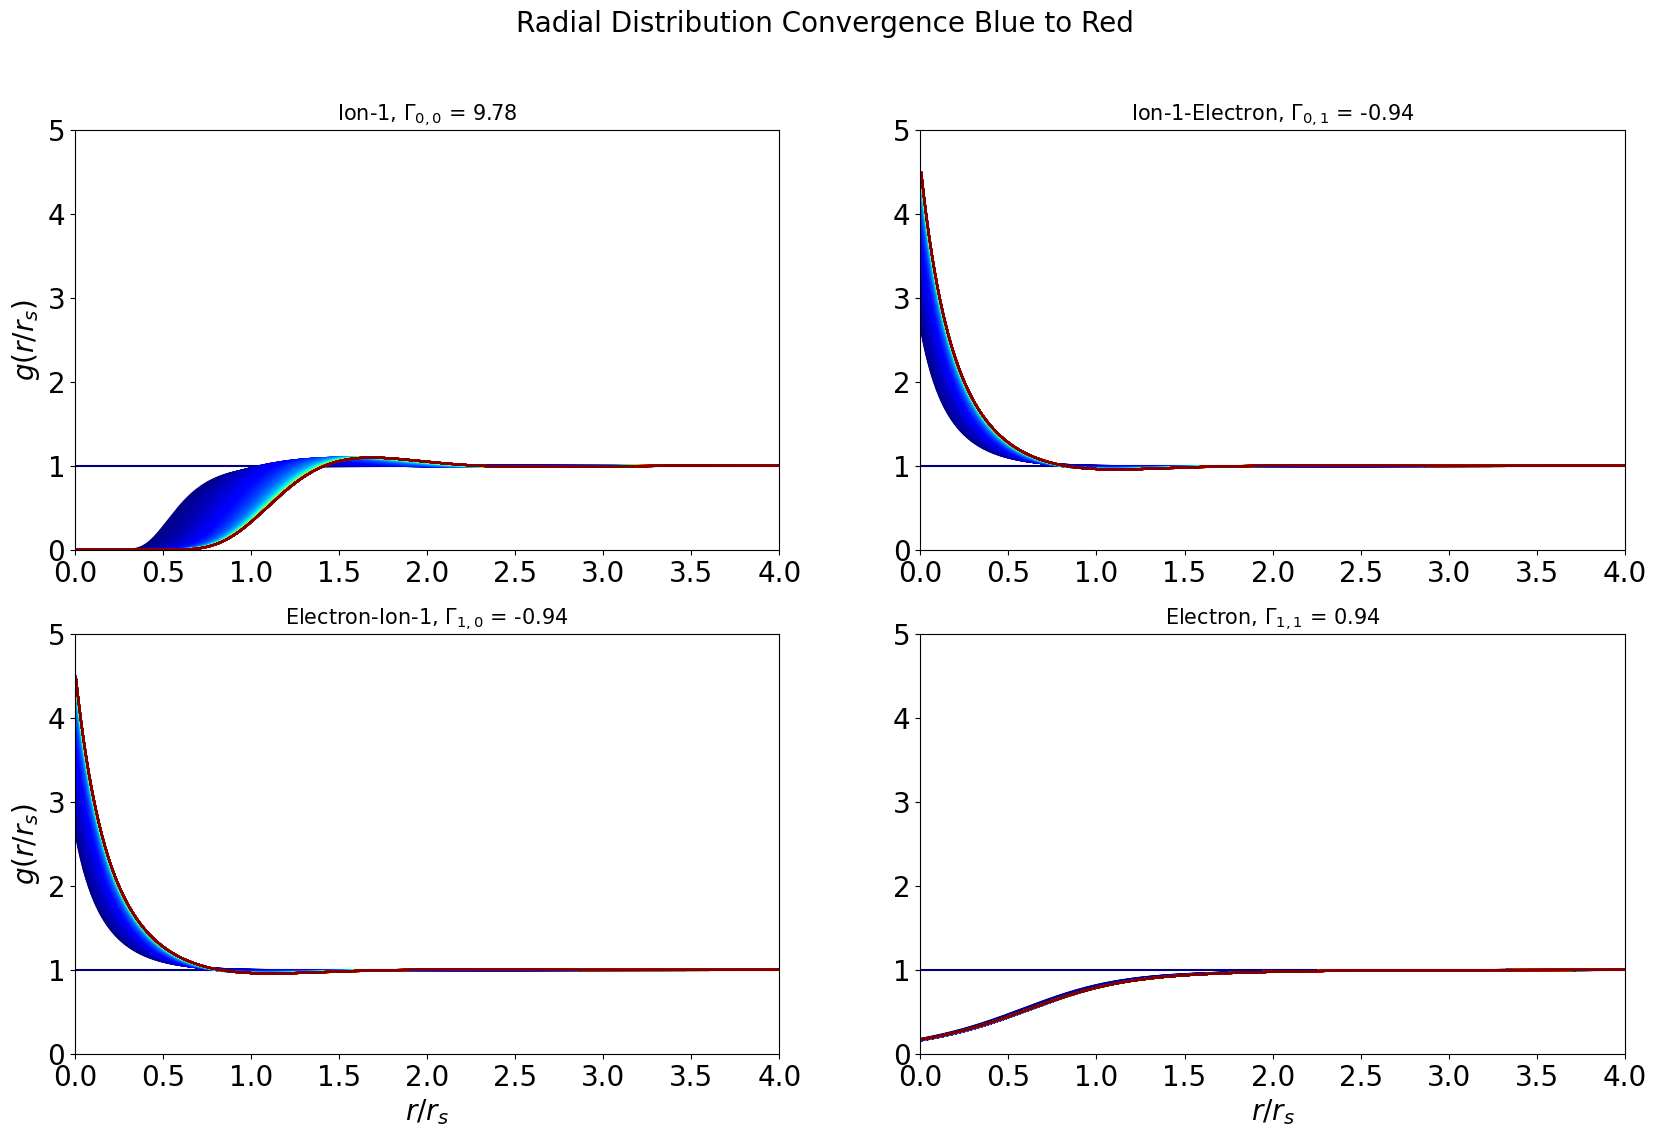

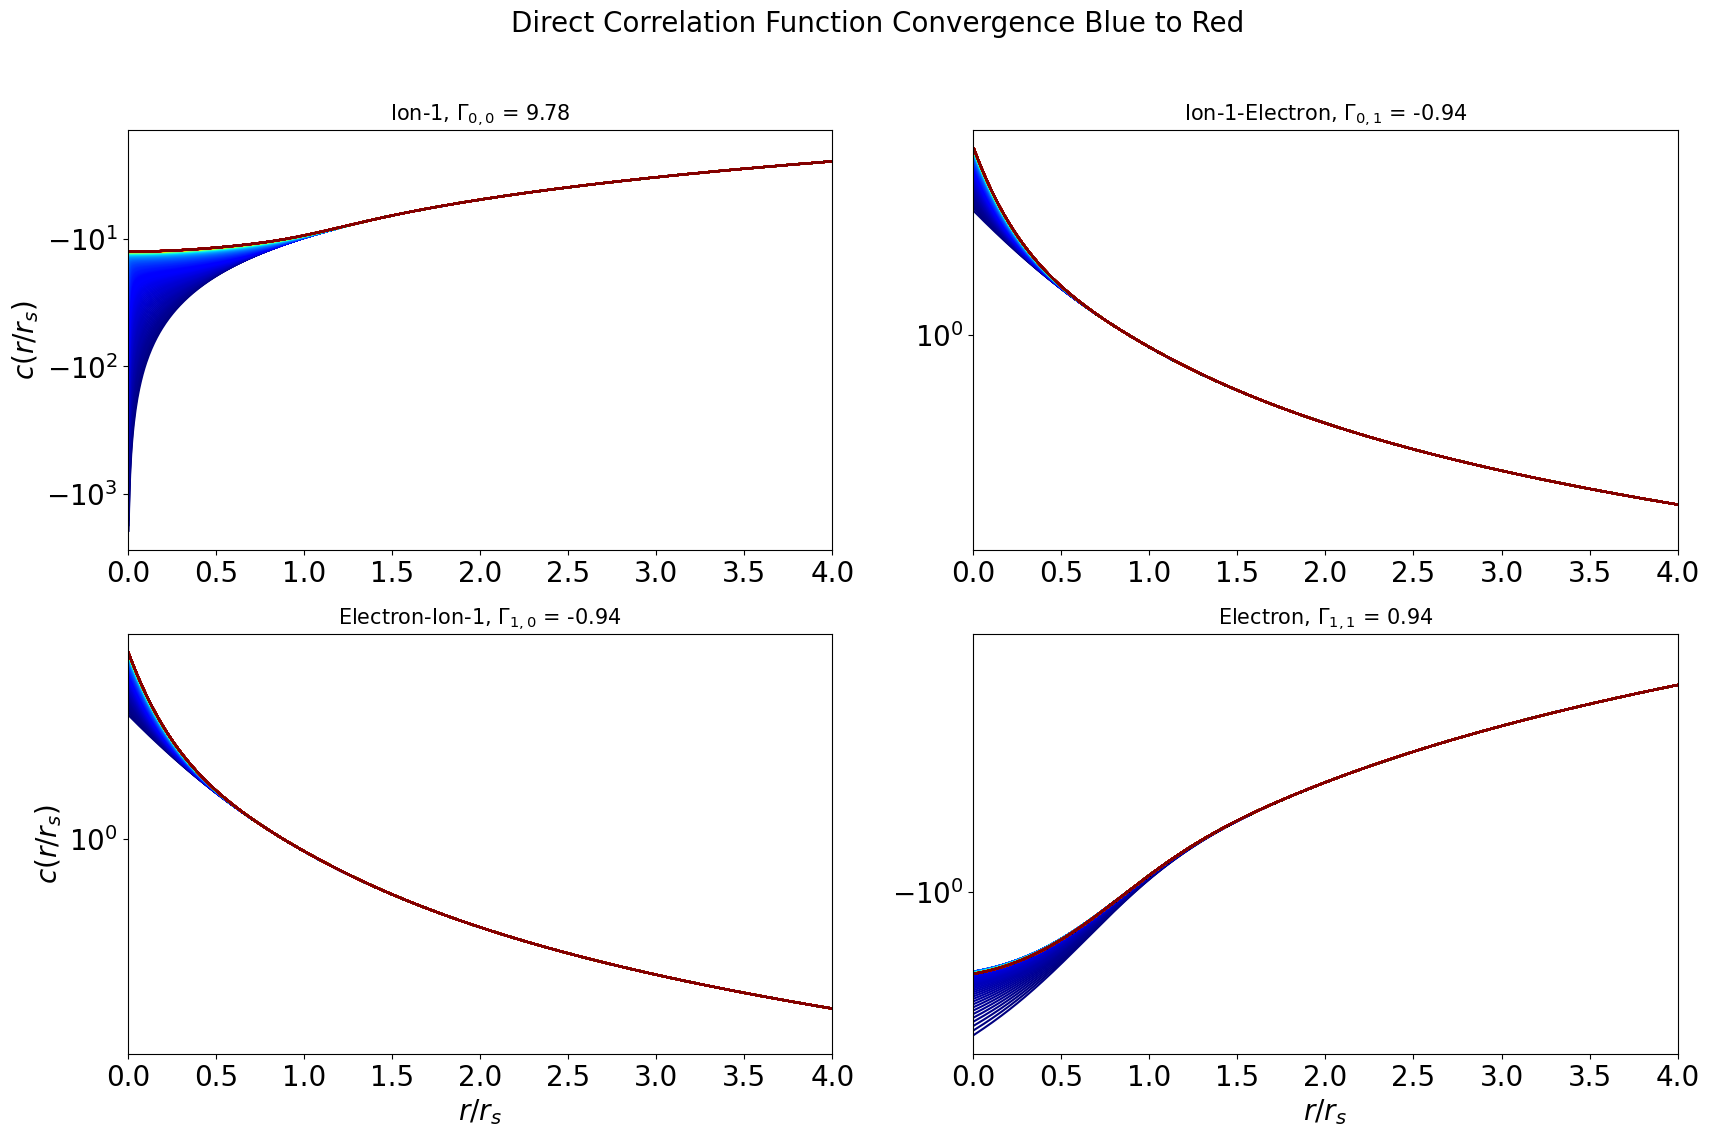

In [16]:
hydrogen.plot_species_convergence_g(n_slices= int(len(hydrogen.h_list)/1)  )
hydrogen.plot_species_convergence_c(n_slices= int(len(hydrogen.h_list)/1)  )

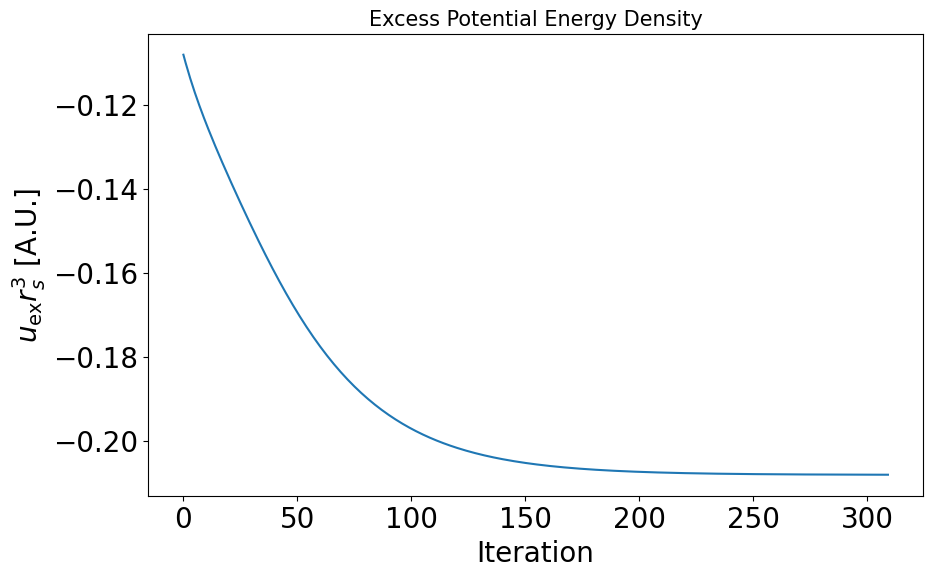

In [19]:
hydrogen.plot_convergence_uex()

In [23]:
hydrogen_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar , method='fixed',alpha=0.1)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 7.39e+00, OZ: 2.50e-01, HNC: 5.71e-02, tot: 0.33
1: Err in c_r: 6.69e+00, OZ: 2.44e-01, HNC: 4.51e-02, tot: 0.33
2: Err in c_r: 6.05e+00, OZ: 2.38e-01, HNC: 3.83e-02, tot: 0.34
3: Err in c_r: 5.47e+00, OZ: 2.33e-01, HNC: 3.38e-02, tot: 0.34
4: Err in c_r: 4.94e+00, OZ: 2.28e-01, HNC: 3.05e-02, tot: 0.34
5: Err in c_r: 4.47e+00, OZ: 2.23e-01, HNC: 2.81e-02, tot: 0.35
6: Err in c_r: 4.04e+00, OZ: 2.18e-01, HNC: 2.62e-02, tot: 0.35
7: Err in c_r: 3.66e+00, OZ: 2.13e-01, HNC: 2.47e-02, tot: 0.36
8: Err in c_r: 3.31e+00, OZ: 2.08e-01, HNC: 2.34e-02, tot: 0.36
9: Err in c_r: 2.99e+00, OZ: 2.04e-01, HNC: 2.24e-02, tot: 0.36
10: Err in c_r: 2.70e+00, OZ: 2.00e-01, HNC: 2.16e-02, tot: 0.37
11: Err in c_r: 2.44e+00, OZ: 1.96e-01, HNC: 2.09e-02, tot: 0.37
12: Err in c_r: 2.21e+00, OZ: 1.91e-01, HNC: 2.03e-02, tot: 0.37
13: Err in c_r: 2.00e+00, OZ: 1.87e-01, HNC: 1.98e-02, tot: 0.38
14: Err i

167: Err in c_r: 1.06e-03, OZ: 4.15e-03, HNC: 5.58e-04, tot: 0.47
168: Err in c_r: 1.04e-03, OZ: 4.04e-03, HNC: 5.43e-04, tot: 0.47
169: Err in c_r: 1.01e-03, OZ: 3.93e-03, HNC: 5.28e-04, tot: 0.47
170: Err in c_r: 9.80e-04, OZ: 3.83e-03, HNC: 5.14e-04, tot: 0.47
171: Err in c_r: 9.54e-04, OZ: 3.73e-03, HNC: 5.01e-04, tot: 0.47
172: Err in c_r: 9.28e-04, OZ: 3.63e-03, HNC: 4.87e-04, tot: 0.47
173: Err in c_r: 9.03e-04, OZ: 3.53e-03, HNC: 4.74e-04, tot: 0.47
174: Err in c_r: 8.78e-04, OZ: 3.44e-03, HNC: 4.62e-04, tot: 0.47
175: Err in c_r: 8.54e-04, OZ: 3.35e-03, HNC: 4.49e-04, tot: 0.47
176: Err in c_r: 8.31e-04, OZ: 3.26e-03, HNC: 4.37e-04, tot: 0.47
177: Err in c_r: 8.09e-04, OZ: 3.17e-03, HNC: 4.26e-04, tot: 0.47
178: Err in c_r: 7.87e-04, OZ: 3.08e-03, HNC: 4.14e-04, tot: 0.47
179: Err in c_r: 7.65e-04, OZ: 3.00e-03, HNC: 4.03e-04, tot: 0.47
180: Err in c_r: 7.45e-04, OZ: 2.92e-03, HNC: 3.93e-04, tot: 0.47
181: Err in c_r: 7.24e-04, OZ: 2.84e-03, HNC: 3.82e-04, tot: 0.47
182: Err i

330: Err in c_r: 1.25e-05, OZ: 4.97e-05, HNC: 6.68e-06, tot: 0.47
331: Err in c_r: 1.22e-05, OZ: 4.84e-05, HNC: 6.50e-06, tot: 0.47
332: Err in c_r: 1.18e-05, OZ: 4.71e-05, HNC: 6.33e-06, tot: 0.47
333: Err in c_r: 1.15e-05, OZ: 4.58e-05, HNC: 6.16e-06, tot: 0.47
334: Err in c_r: 1.12e-05, OZ: 4.46e-05, HNC: 6.00e-06, tot: 0.47
335: Err in c_r: 1.09e-05, OZ: 4.34e-05, HNC: 5.83e-06, tot: 0.47
336: Err in c_r: 1.06e-05, OZ: 4.22e-05, HNC: 5.68e-06, tot: 0.47
337: Err in c_r: 1.03e-05, OZ: 4.11e-05, HNC: 5.53e-06, tot: 0.47
338: Err in c_r: 1.00e-05, OZ: 4.00e-05, HNC: 5.38e-06, tot: 0.47
339: Err in c_r: 9.78e-06, OZ: 3.89e-05, HNC: 5.23e-06, tot: 0.47


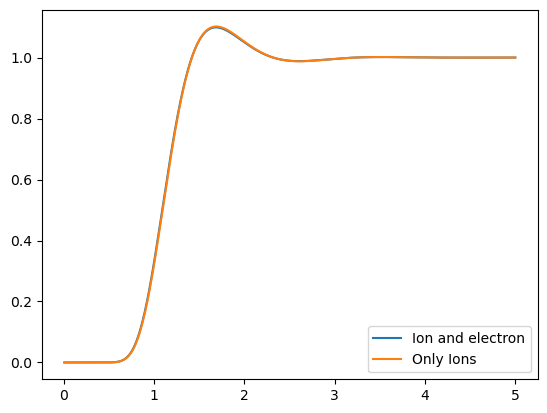

In [24]:
fig, ax = plt.subplots()

ax.plot(hydrogen.r_array, hydrogen.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(hydrogen.r_array, hydrogen_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Aluminum

In [48]:
K_to_eV = 1/11606.

In [58]:
ni = 6.03e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 13,27
Zstar= 3
# aluminum_i_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar, num_iterations=1e3,method='fixed', alpha=1)
# aluminum_e_one_species,_ = run_hnc_one_electron(Zstar*ni, Te, 1, m_e/m_p, 1, num_iterations=1e3,method='fixed',alpha=1 )


In [59]:
# aluminum_i_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_i_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_i_one_species.plot_species_convergence_ck(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_i_one_species.plot_convergence_uex()

# aluminum_e_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_e_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_e_one_species.plot_species_convergence_ck(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
# aluminum_e_one_species.plot_convergence_uex()

In [60]:
# c_k_guess = np.zeros((2,2,N_bins))
# c_k_guess[0,0] = aluminum_i_one_species.c_k_matrix
# c_k_guess[1,1] = aluminum_e_one_species.c_k_matrix

In [62]:
aluminum, aluminumqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=2e3, method='best', alpha=0.5)#, c_k_guess=c_k_guess )

Λei = 0.222
Λee = 0.313
Λei adjusted with R = 0.222
Γii=81.917, Γie=-2.769, Γee=0.923 
r_i=2.989
r_e=2.073
θ  =8.57e-02
0: Err in c_r: 3.55e+02, OZ: 6.38e-02, HNC: 6.19e+01, tot: 3.55e+02, tot: 3.65e+02
1: Err in c_r: 1.82e+02, OZ: 5.97e-02, HNC: 5.18e-01, tot: 1.82e+02, tot: 1.88e+02
HNC αs: [1. 0. 0.], c_err: 2.98068e+92 
HNC αs: [1. 0. 0.], c_err: 2.98068e+92 
HNC αs: [1.0e+00 2.5e-04 0.0e+00], c_err: 3.18810e+92 
HNC αs: [1.0e+00 0.0e+00 2.5e-04], c_err: 3.19439e+92 
HNC αs: [1.00000000e+00 1.66666667e-04 0.00000000e+00], c_err: 3.11740e+92 
HNC αs: [1. 0. 0.], c_err: 2.98068e+92 
HNC αs: [1. 0. 0.], c_err: 2.98068e+92 
HNC αs: [1. 0. 0.], c_err: 2.98068e+92 
 HNC min: [1. 0. 0.] True Optimization terminated successfully.
2: Err in c_r: 8.51e+01, OZ: 7.41e+01, HNC: inf, tot: 1.55e+02, tot: 2.98e+92
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.0e+00 2.5e-04 0.0e+00], c_err: inf 
HNC αs: [1.0e+00 0.0e+00 2.5e-04], c_err: inf 
HNC αs: [1.00000000e+00 1.66

/home/zach/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


HNC αs: [1.00000000e+00 1.62760417e-07 4.88281250e-07], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.0000000e+00 4.8828125e-07 0.0000000e+00], c_err: inf 
HNC αs: [1.0000000e+00 0.0000000e+00 4.8828125e-07], c_err: inf 
HNC αs: [1.00000000e+00 3.25520833e-07 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 8.13802083e-08 2.44140625e-07], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 2.44140625e-07 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 2.44140625e-07], c_err: inf 
HNC αs: [1.00000000e+00 1.62760417e-07 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 4.06901042e-08 1.22070313e-07], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 1.22070313e-07 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 1.22070313e-07], c_err: inf 
HNC αs: [1.00000000e+00 8.13802083e-08 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 2.03450521e-08 6.10351563e-08], c_err: inf 
HNC αs: [1. 0. 0.], c_err:

HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.0000000e+00 1.8189894e-15 0.0000000e+00], c_err: inf 
HNC αs: [1.0000000e+00 0.0000000e+00 1.8189894e-15], c_err: inf 
HNC αs: [1.0000000e+00 1.2126596e-15 0.0000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 3.03164901e-16 9.09494702e-16], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 9.09494702e-16 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 9.09494702e-16], c_err: inf 
HNC αs: [1.00000000e+00 6.06329801e-16 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 1.51582450e-16 4.54747351e-16], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 4.54747351e-16 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 4.54747351e-16], c_err: inf 
HNC αs: [1.00000000e+00 3.03164901e-16 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 7.57912251e-17 2.27373675e-16], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 2.27373675e-16 0.00000000e+00], c_err: in

HNC αs: [1.00000000e+00 1.35525272e-23 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 1.35525272e-23], c_err: inf 
HNC αs: [1.0000000e+00 9.0350181e-24 0.0000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 2.25875453e-24 6.77626358e-24], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 6.77626358e-24 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 6.77626358e-24], c_err: inf 
HNC αs: [1.00000000e+00 4.51750905e-24 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 1.12937726e-24 3.38813179e-24], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 3.38813179e-24 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 3.38813179e-24], c_err: inf 
HNC αs: [1.00000000e+00 2.25875453e-24 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 5.64688632e-25 1.69406589e-24], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 1.69406589e-24 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00

HNC αs: [1.00000000e+00 5.04870979e-32 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 5.04870979e-32], c_err: inf 
HNC αs: [1.00000000e+00 3.36580653e-32 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 8.41451632e-33 2.52435490e-32], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.0000000e+00 2.5243549e-32 0.0000000e+00], c_err: inf 
HNC αs: [1.0000000e+00 0.0000000e+00 2.5243549e-32], c_err: inf 
HNC αs: [1.00000000e+00 1.68290326e-32 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 4.20725816e-33 1.26217745e-32], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 1.26217745e-32 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 1.26217745e-32], c_err: inf 
HNC αs: [1.00000000e+00 8.41451632e-33 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 2.10362908e-33 6.31088724e-33], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 6.31088724e-33 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.

HNC αs: [1.00000000e+00 1.58945719e-10 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 3.97364299e-11 1.19209290e-10], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.0000000e+00 1.1920929e-10 0.0000000e+00], c_err: inf 
HNC αs: [1.0000000e+00 0.0000000e+00 1.1920929e-10], c_err: inf 
HNC αs: [1.00000000e+00 7.94728597e-11 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 1.98682149e-11 5.96046448e-11], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 5.96046448e-11 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 5.96046448e-11], c_err: inf 
HNC αs: [1.00000000e+00 3.97364299e-11 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 9.93410746e-12 2.98023224e-11], c_err: inf 
HNC αs: [1. 0. 0.], c_err: inf 
HNC αs: [1.00000000e+00 2.98023224e-11 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 0.00000000e+00 2.98023224e-11], c_err: inf 
HNC αs: [1.00000000e+00 1.98682149e-11 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 4.

KeyboardInterrupt: 

In [14]:
aluminumqsp.Te, aluminumqsp.Te_c, aluminumqsp.Tq, aluminumqsp.Ti 

(0.0367512, 0.36242319501279524, 0.3605550187999643, 0.0367512)

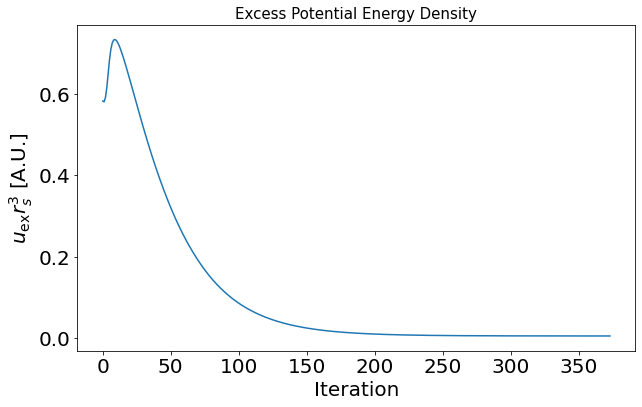

In [15]:
aluminum.plot_convergence_uex()


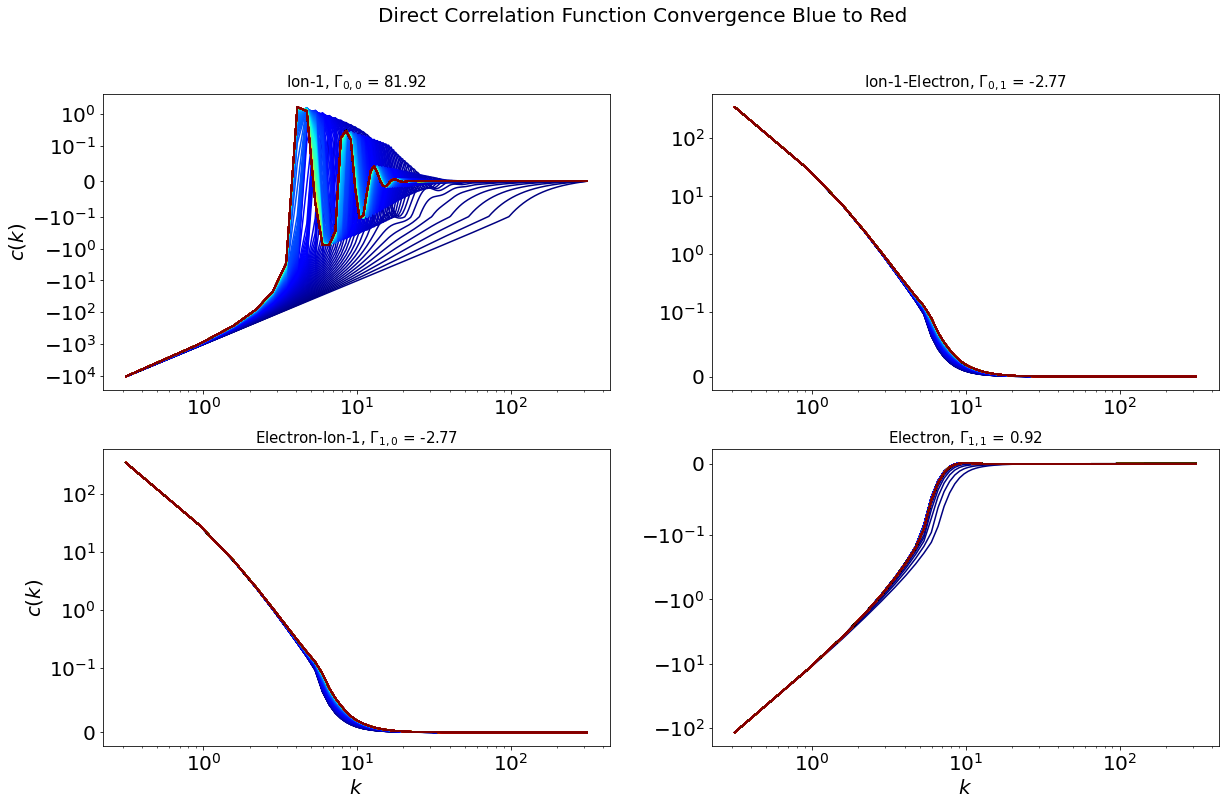

In [16]:
aluminum.plot_species_convergence_ck(n_slices= int(len(aluminum.h_list)/1)  )

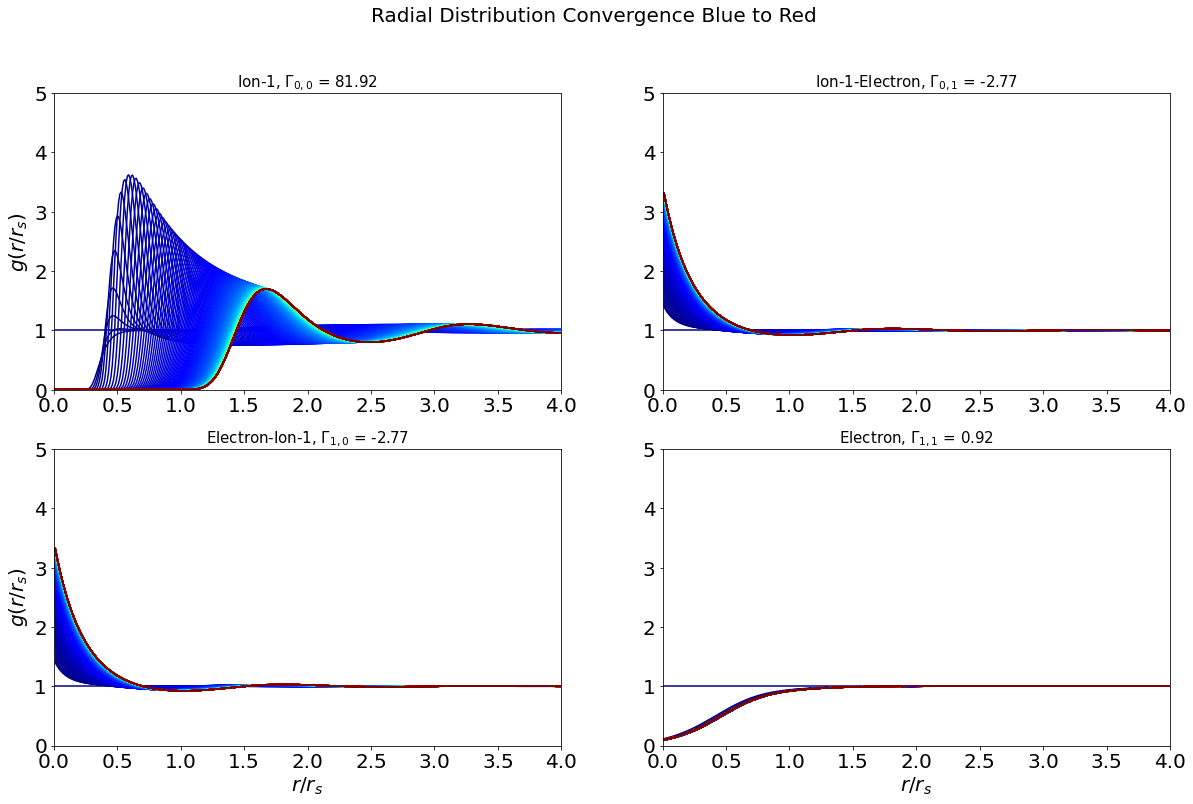

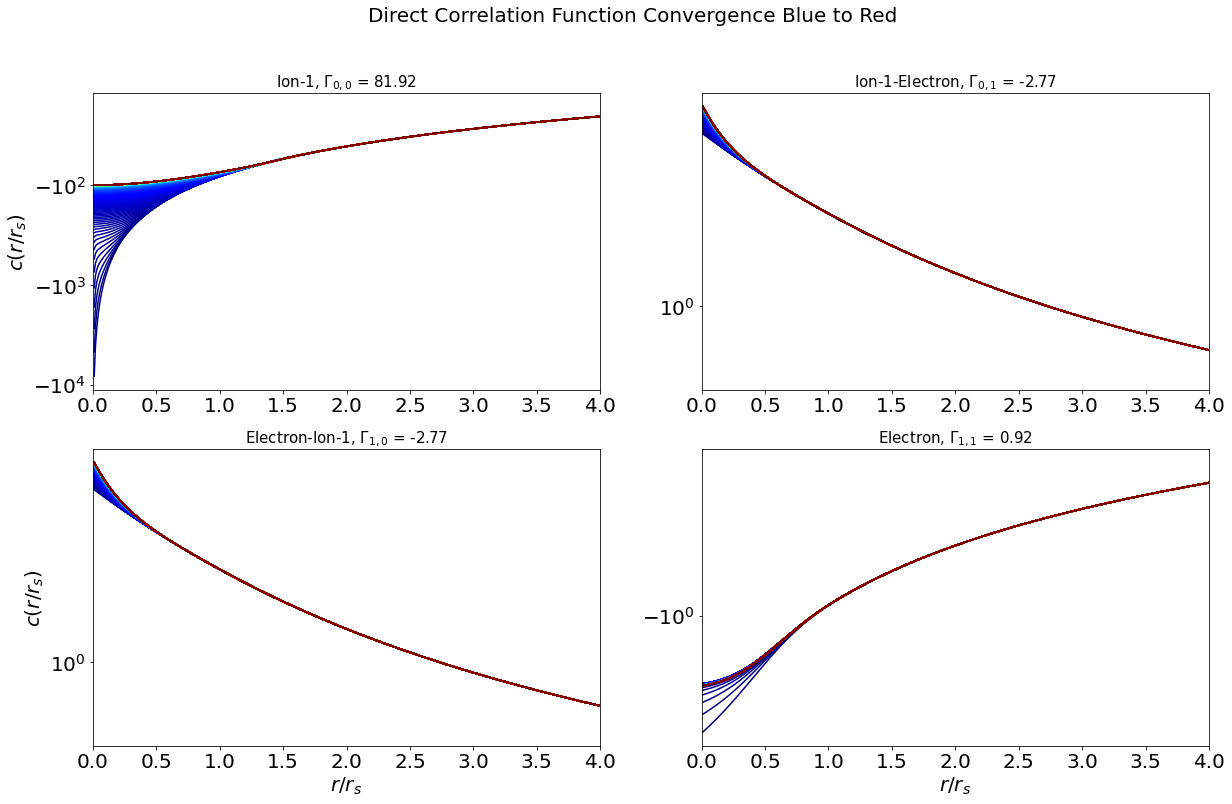

In [17]:
aluminum.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )


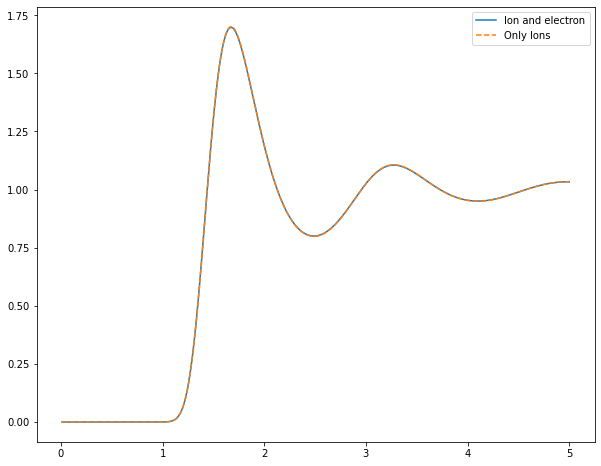

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(aluminum.r_array, aluminum.h_r_matrix[0,0] + 1, label='Ion and electron')
ax.plot(aluminum_i_one_species.r_array, aluminum_i_one_species.h_r_matrix[0,0]+1,'--', label="Only Ions")
ax.legend()
